# Proyecto de predicción del precio de las acciones de ElectroStock

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

# Configure matplotlib plotting
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9 #Changes default matplotlib plots to this size

## Exploratory Data Analysis

We need to first check a few things:

Duplicate and missing data, as well as spread
How autocorrelated is this data and its seasonal decomposition

In [2]:
# Load my EDA helper function created to do some high-level analysis
class EDA():

    df = pd.DataFrame()
    
    def __init__(self, df):
        '''
        Creates EDA object for the DataFrame
        
        Note for time series data, have the index be the timestamp prior to creating this Object.
        
        :param df : DataFrame
        '''
        self.df = df
        
    def missing_values(self):
        '''
        Checks missing values
        
        :return DataFrame
        
        '''
        missing = self.df[self.df.isna().any(axis=1)]
        
        print("Missing values data")
        
        return missing
    
    def duplicate_values(self):
        duplicates = self.df[self.df.duplicated(subset=None, keep='first')==True]
        
        print("Duplicate values data")
        
        return duplicates
        
    def duplicate_indices(self):
        '''
        Check whether the indices have any duplicates
        
        :return DataFrame
        '''        
        duplicate_indices = self.df[self.df.index.duplicated()==True]
        
        print("Duplicate indices")
        
        return duplicate_indices
            
    def summary(self):
        '''
        Return summary/describe of DataFrame
        
        :return DataFrame
        '''
        df = self.df.reset_index() # Reset to include the index
        
        summary = df.describe(include='all').transpose()
        
        print("Summary metrics")
        
        return summary
    
    def pandas_profiling(self):
        import pandas_profiling
        
        self.df.profile_report(style={'full_width':True})  
    
    def histogram_KDE(self):
        ''' 
        :return seaborn plot
        '''       
        sns.pairplot(self.df, diag='kde')
        sns.distplot(kde=True, fit=[st.norm or st.lognorm])
        
    def outliers(self, col):
        ''' 
        Checks outliers - anything outside of 5% to 95% quartile range
        
        :param col : str
            Name of col to be tested
            
        :return DataFrame
        '''
        outliers = self.df[~self.df[col].between(self.df[col].quantile(.05), self.df[col].quantile(.95))]
        
        print("Outliers")
        
        return outliers
        
    def missing_timeseries_points(self, freq='D'):
        '''
        Checks whether there's any missing data points in continuous time series data.
        
        :param freq optional default = 'D' : str
            Frequency compliant with pandas formatting
        
        :return DataFrame
        '''
        # First create date range
        date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq=freq)

        # Now compare against dataset
        missing_timeseries = self.df.index[~self.df.index.isin(date_range)]
        
        print("Missing timeseries data")
        
        return missing_timeseries

    def corr_heatmap(df):
        fig, ax = plt.subplots(figsize=(10, 6))
        corr = self.df.corr()
        hm = sns.heatmap(round(corr,2), annot=True, cmap="coolwarm",fmt='.2f', linewidths=.05)
        fig.subplots_adjust(top=0.93)
        title = fig.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

        plt.show()

    def plot_time_series_seasonal_decomp(self, type='add'):
        '''
        Plots seasonal decomposition of timeseries data
        
        :return matplotlib Plot
        '''
        from statsmodels.tsa.seasonal import seasonal_decompose
        decomposition = seasonal_decompose(self.df, model='multiplicative')

        fig = decomposition.plot()
        plt.show()
   
    def time_series_ADF(self):            
        '''
        Returns Augmented Dickey-Fuller Test
        '''
        from statsmodels.tsa.stattools import adfuller as ADF

        series = data['Electricity'] # ADF takes series, not DF

        result = ADF(series)

        print('ADF Statistic: %f4.2' % result[0])
        print('P-value %f4.2' % result[1])

In [3]:
data = pd.read_csv('acciones_electrostock.csv', sep =',')
data = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
data.set_index('Date',inplace=True)

data.index = pd.to_datetime(data.index)

data_copy = data.copy(deep=True) # Make a deep copy, including a copy of the data and the indices
data.head(10)

,Close
Date,
2022-07-05,51.150002
2022-07-06,49.060001
2022-07-07,50.279999
2022-07-08,50.130001
2022-07-11,49.450001
2022-07-12,48.349998
2022-07-13,48.980000
2022-07-14,46.299999
2022-07-15,47.930000


In [4]:
eda_helper = EDA(data)

eda_helper.summary()

Summary metrics


/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/3500455128.py:56: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  summary = df.describe(include='all').transpose()


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Date,251,251,2022-07-05,1,2022-07-05,2023-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Close,251.0,NaN,NaT,NaN,NaT,NaT,57.296096,5.352716,44.860001,52.065,58.860001,61.810001,64.949997


In [5]:
eda_helper.missing_values()

Missing values data


,Close
Date,


In [6]:
eda_helper.duplicate_indices()

Duplicate indices


,Close
Date,


In [7]:
# Given there's no missing data, we can resample the data to daily level
daily_data = data.resample(rule='D').sum()
# Rellenar los valores 0.00 con el valor anterior
daily_data['Close'] = daily_data['Close'].replace(0.00000, method='ffill')
# Set frequency explicitly to D
daily_data = daily_data.asfreq('D')


daily_data.head(10)

,Close
Date,
2022-07-05,51.150002
2022-07-06,49.060001
2022-07-07,50.279999
2022-07-08,50.130001
2022-07-09,50.130001
2022-07-10,50.130001
2022-07-11,49.450001
2022-07-12,48.349998
2022-07-13,48.980000


In [8]:
daily_data.index

DatetimeIndex(['2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08',
               '2022-07-09', '2022-07-10', '2022-07-11', '2022-07-12',
               '2022-07-13', '2022-07-14',
               ...
               '2023-06-24', '2023-06-25', '2023-06-26', '2023-06-27',
               '2023-06-28', '2023-06-29', '2023-06-30', '2023-07-01',
               '2023-07-02', '2023-07-03'],
              dtype='datetime64[ns]', name='Date', length=364, freq='D')

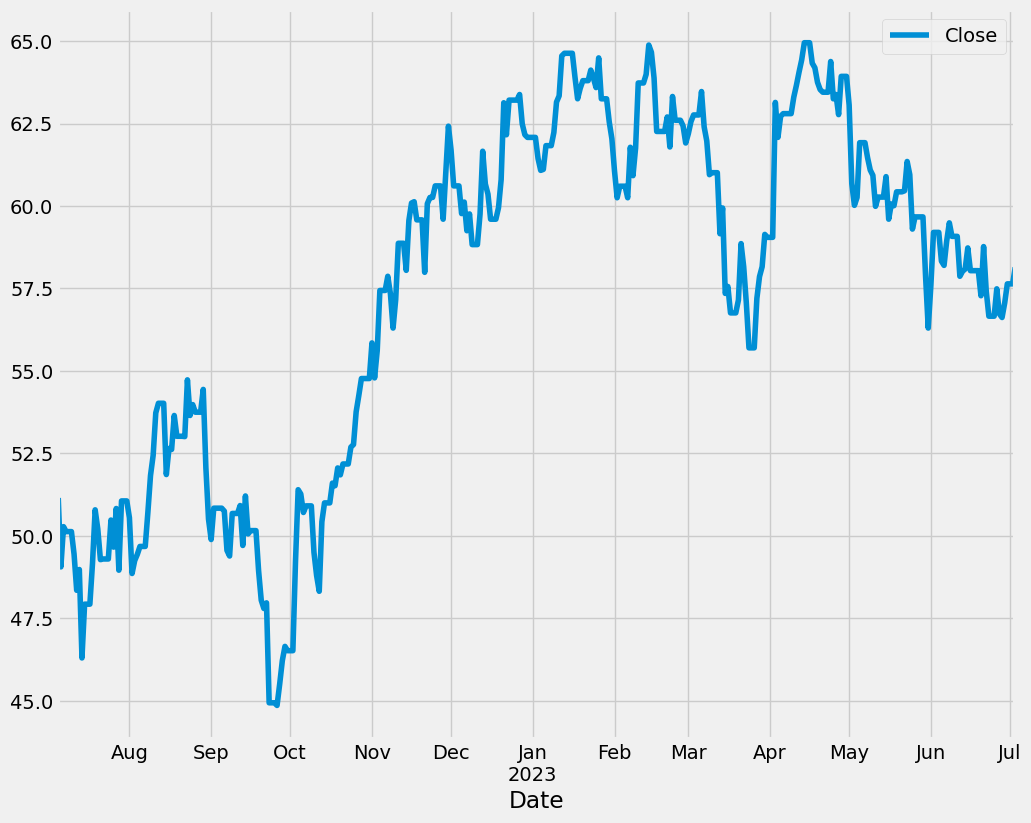

In [9]:
daily_data.plot()

plt.show()

### Seasonal Decomposition

At a high-level, time series data can be thought of as components put together. That is:

Data = Level + Trend + Seasonality + Noise

Level: the average value in the series.
Trend: the increasing or decreasing value in the series.
Seasonality: the repeating short-term cycle in the series.
Noise/Residual: the random variation in the series.
Using the Python statsmodel library, the above components can be 'decomposed' (ie seasonal decomposition):

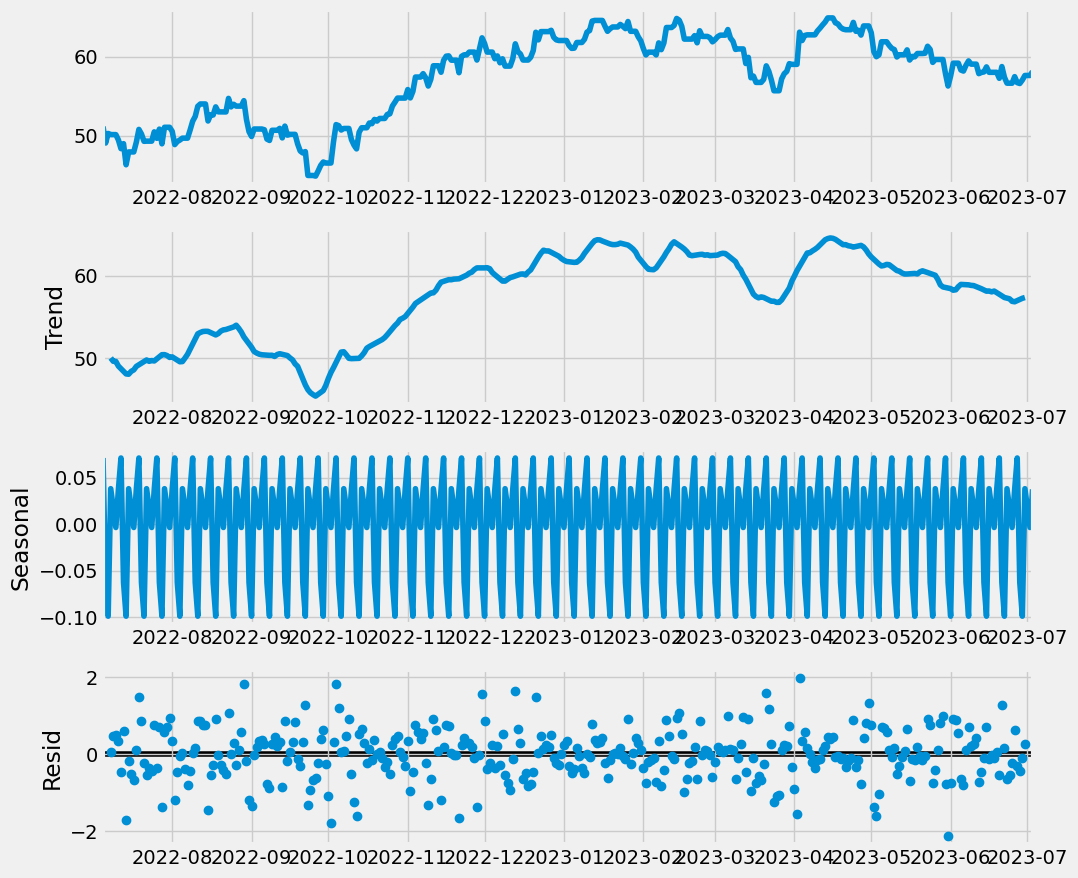

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(daily_data, model='additive')

fig = decomposition.plot()
plt.show()

Another way to visualise seasonality is to use a heatmap - we can base it on a week to see which days high price of Close.

In [11]:
daily_data.index.day_name()

Index(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       ...
       'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Monday'],
      dtype='object', name='Date', length=364)

In [12]:
# Create new dataset for heatmap
heatmap_data = daily_data.copy()

# First we need to add weekdays as a column
heatmap_data['Weekday_Name'] = daily_data.index.day_name()

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Weekday_Name']).sum()

# Reset index 
heatmap_data = heatmap_data.reset_index()


# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Weekday_Name', values='Close')

# Reorder columns
heatmap_data = heatmap_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

heatmap_data.head(100)

Weekday_Name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Year,,,,,,,
2022,1339.219986,1398.370003,1397.149996,1396.129994,1401.720003,1401.720003,1339.640001
2023,1652.080001,1588.730001,1582.110003,1583.580000,1586.019982,1586.019982,1648.099984


Text(0.5, 1.0, 'Heatmap - by Day of Week')

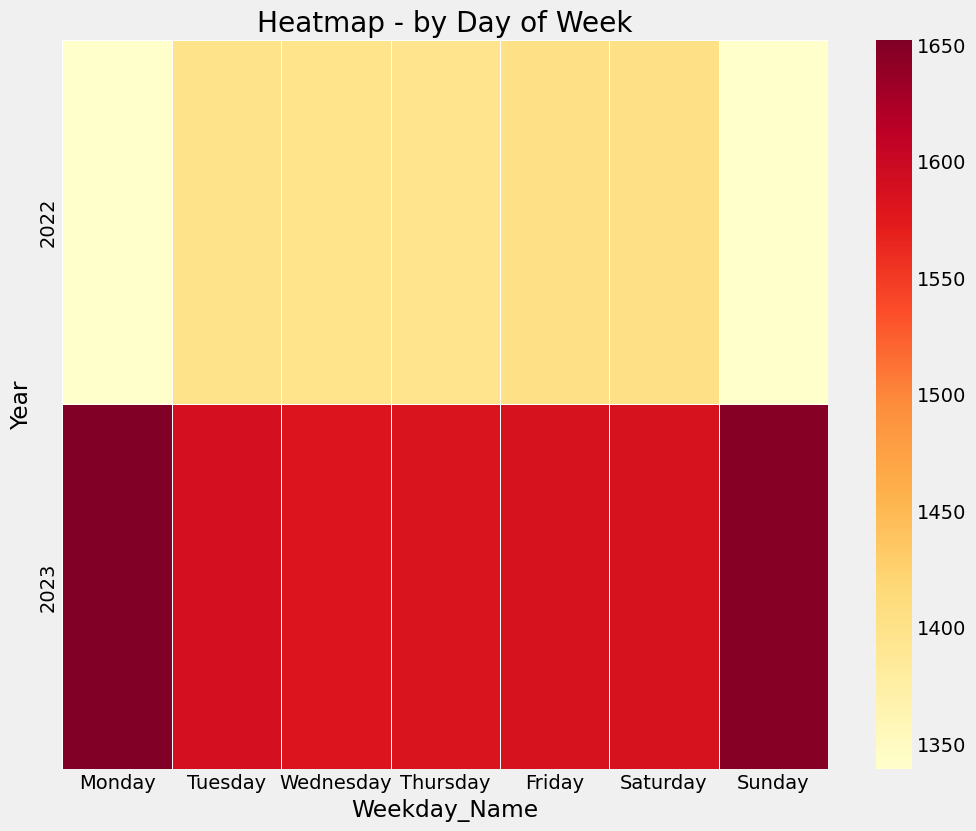

In [13]:
# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f'}).set_title('Heatmap - by Day of Week')

In [14]:
# Create new dataset for heatmap
heatmap_data = daily_data.copy()

# First we need to add weekdays as a column
heatmap_data['Month'] = daily_data.index.month_name()

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Month']).sum()

# Reset index
heatmap_data = heatmap_data.reset_index()


# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Month', values='Close')

# Reorder columns
heatmap_data = heatmap_data[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]

heatmap_data.head(10)

Month,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2022,NaN,NaN,NaN,NaN,NaN,NaN,1338.210001,1621.39,1464.709993,1594.549994,1763.849996,1891.240002
2023,1957.620004,1745.409982,1838.879992,1899.259988,1870.799976,1741.250014,173.419997,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Heatmap - by Month of Week')

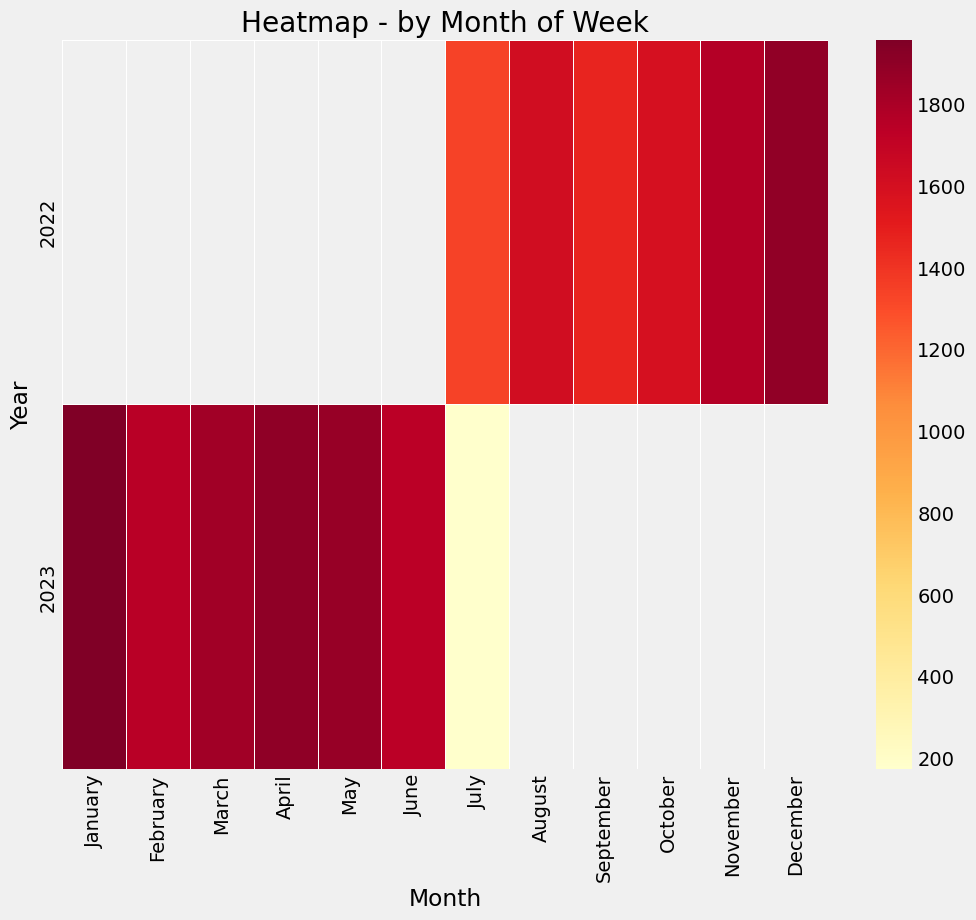

In [15]:
# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f'}).set_title('Heatmap - by Month of Week')

### Prueba estadística 'Alarmas de humo' 'Smoke Alarms'

Las pruebas estadísticas son una buena manera de comprobar si los datos son adecuados para los métodos estadísticos convencionales.

Existen ciertas pruebas estadísticas que puedes aplicar a un conjunto de datos como una "prueba de alarma de humo". Son una buena indicación de si los datos son propicios para un pronóstico preciso.

Ambas pruebas estadísticas que se describen a continuación utilizan la Prueba de Hipótesis y los valores p (p-values), que requieren que se elija un umbral de antemano. La regla general es un 5%: lo que significa que solo hay un 5% de probabilidad de que las pruebas estadísticas sean incorrectas.

Si P-Value es >0.05 Data No es HETEROSKEDACTIC y no es estacionaria; p-Value<0.05 DAta es HETEROSKEDACTIC y es estacionaria.

'Estacionario' significa que las propiedades del conjunto de datos no cambian con el tiempo. No estacionario significa que las tendencias y la estacionalidad cambian con el tiempo y que los datos se ven afectados por factores distintos al paso del tiempo. Un conjunto de datos no estacionario a veces se conoce como una "Caminata Aleatoria", lo que los hace notoriamente difíciles de pronosticar, porque las propiedades subyacentes siguen cambiando (por ejemplo, como tratar de acertar a un objetivo en movimiento).

Es importante destacar que una Caminata Aleatoria es diferente a un conjunto de "números aleatorios". Es aleatorio porque el siguiente punto se basa en una modificación "aleatoria" del primer punto (por ejemplo, sumar, restar, multiplicar). Mientras que en un conjunto de "números aleatorios", habría poca relación entre cada punto de datos.

In [16]:
#So let's run the test for Stationarity and see the results:

from statsmodels.tsa.stattools import adfuller as ADF

series = daily_data['Close'] # ADF takes series, not DF

result = ADF(series)

print('ADF Statistic: ', result[0])
print('P-value: {:.20f}'.format(result[1]))

ADF Statistic:  -1.753973715127765
P-value: 0.40353980048159499017


'Heteroskedasticity' se refiere a casos en los que los datos se distribuyen de manera uniforme a lo largo de una línea de regresión. Básicamente, esto significa que los datos están más cercanamente agrupados y, por lo tanto, son menos "puntuales" (es decir, tienen más picos y valles).

Los datos heteroskedásticos implican que los picos y valles (es decir, valores atípicos) se observan mucho más frecuentemente que en un conjunto de datos con una distribución "normal". Esto significa que un modelo tendrá dificultades para predecir estos picos.

Para mitigar esto, generalmente es necesario transformar los datos heteroskedásticos mediante Box-Cox o logaritmo para reducir los picos y valles extremos. Es decir, llevar los datos más cerca entre sí para que un modelo pueda ajustarse mejor a todo el conjunto de datos e identificar los picos y valles con mayor precisión.

In [17]:
#So let's run the test for Heteroskedacity and see the results:

from statsmodels.stats.diagnostic import het_breuschpagan as BP
import statsmodels.api as sm
from statsmodels.formula.api import ols

bp_data = daily_data.copy()
bp_data['Time_Period'] = range(1, len(bp_data)+1) # Convert time series points into consecutive ints

formula = 'Close ~ Time_Period' # ie PJME MW depends on Time Period (OLS auto adds Y intercept)

# Next we apply Ordinary Linear Square baseline regression model - as baseline test
model = ols(formula, bp_data).fit()

result = BP(model.resid, model.model.exog)

print('ADF Statistic: ', result[0])
print('P-value: {:.20f}'.format(result[1]))


ADF Statistic:  6.177880124225851
P-value: 0.01293571669645691286


En nuestro caso, obtuvimos los resultados anteriores, lo que significa:

Los datos no son estacionarios (ya que el valor P fue mayor a 0.05).
Los datos no son heteroskedásticos (ya que el valor P si fue inferior a 0.05).

Autocorrelación
La autocorrelación es básicamente cuánta correlación existe entre un punto de tiempo específico y uno anterior, por ejemplo, el valor de hoy está altamente correlacionado con el valor de la semana pasada.

Con, Python Statsmodels tiene una excelente función de autocorrelación (ACF) y veremos esto:

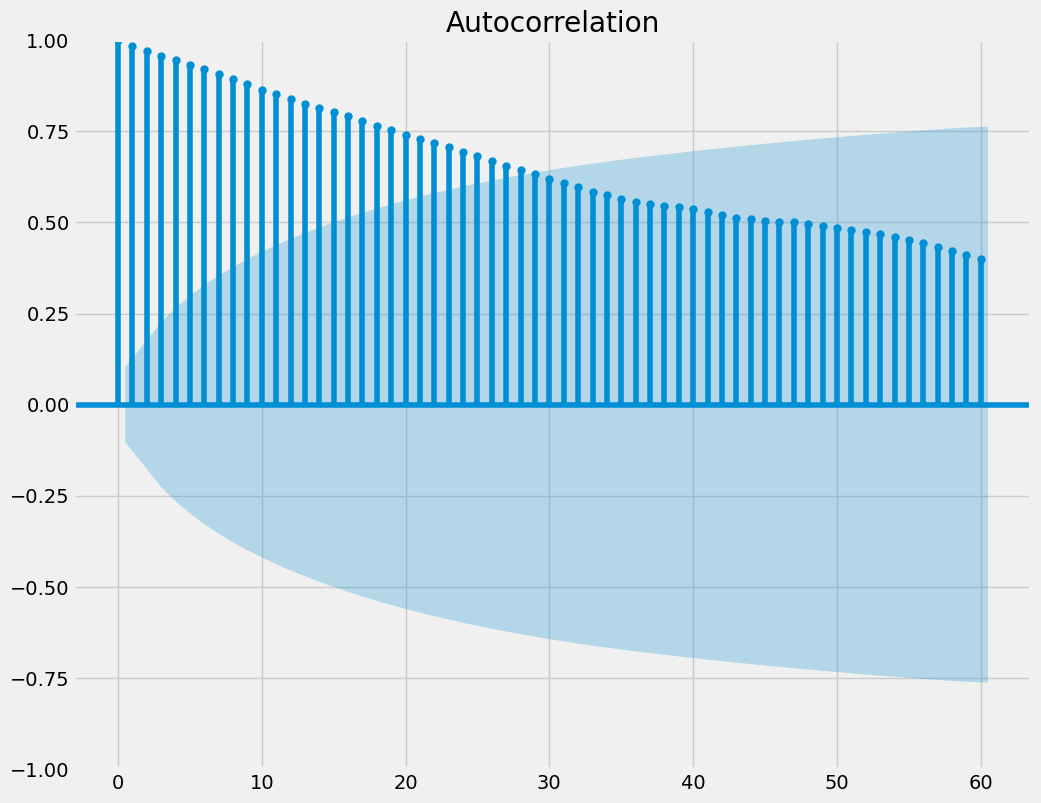

In [18]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#fig, ax = plt.subplots(2,1)

# Plot the acf function
plot_acf(daily_data['Close'],lags=60) #alpha 1 suppresses CI

plt.show()

Lo que muestra el gráfico anterior es cuán correlacionado está un punto anterior con el punto actual. Cuanto más alejado esté el número de 0, mayor será la correlación.

Generalmente, solo consideraríamos como estadísticamente significativos y dignos de mención aquellos puntos que estén por encima (para números positivos) y por debajo (para números negativos) del área sombreada en azul (el intervalo de confianza).

Esto muestra que el valor de ayer tiene una correlación muy alta con el valor de hoy y que hay estacionalidad; se repite cada 30 dias osea 1 mes.

Como se mencionó anteriormente, esto tiene sentido si se tienen en cuenta los patrones climáticos; el invierno y el verano tienen un mayor consumo de electricidad debido a la necesidad de más calefacción/aire acondicionado.

Mi suposición personal es que esto se debe al clima: el invierno y el verano tienen un mayor consumo de electricidad.

Otra modificación de este análisis de autocorrelación es la Función de Autocorrelación Parcial (PACF). Esta función es una variante de ACF, ya que encuentra la correlación de los residuos después de eliminar los efectos que ya se explicaron en retrasos anteriores. De esta manera, no se obtiene un efecto de correlación 'acumulativo'.



/Users/leidygarciaguzman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


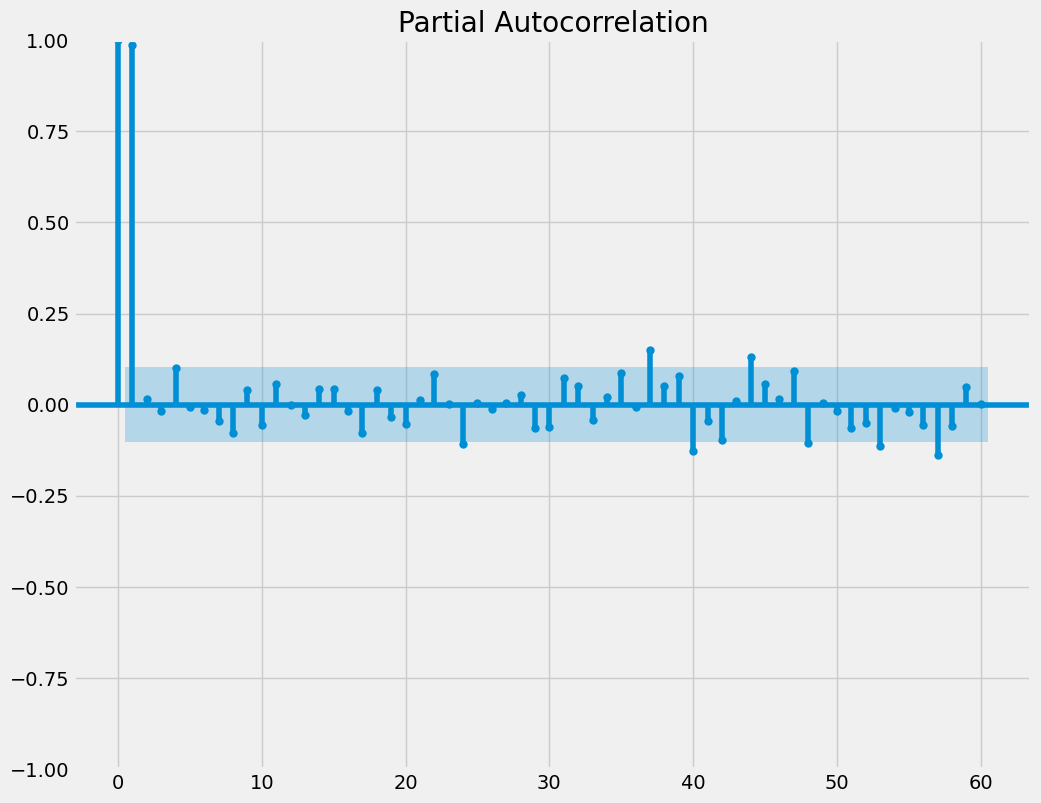

In [19]:
plot_pacf(daily_data['Close'],lags=60) #alpha 1 suppress CI

plt.show()

Train Test Split

Antes de continuar, vamos a dividir los datos en entrenamiento (train) y prueba (test) con una fecha de corte especificada.

In [20]:
cutoff = '2023-03-01'

daily_data.sort_index()

train = daily_data[:cutoff]
test = daily_data[cutoff:]

## Holtwinters Triple Exponential Smoothing (Alisado Exponencial Triple de Holt-Winters)


Holtwinters Triple Exponential Smoothing (Alisado Exponencial Triple de Holt-Winters)
A continuación, utilizaremos un modelo de pronóstico de series temporales que aprovecha las componentes identificadas anteriormente.

Este modelo se conoce como un 'modelo aditivo generativo', ya que el valor final pronosticado se 'suma' a partir de varias componentes.

El término 'Triple' hace referencia a las tres componentes:

Nivel (Level)
Tendencia (Trend)
Estacionalidad (Seasonality)
Holtwinters funciona muy bien cuando los datos tienen estacionalidad y tendencias.

'Alisado' (Smoothing) básicamente significa que se da más peso a los datos más recientes en comparación con el pasado.

Ten en cuenta que los principales hiperparámetros del modelo son:

Aditivo vs Multiplicativo (es decir, 'add' o 'mul')
Box Cox: para utilizar la transformación logarítmica de Box-Cox y reducir el 'ruido' de los datos.
Alpha: factor de alisado entre 0 y 1. 1 significa que siempre se tomará el valor de ayer (pronóstico ingenuo). 0 significa que se tomará el promedio simple del pasado.
El enfoque aditivo significa que la fórmula se ve más o menos así: Datos = Nivel + Tendencia + Estacionalidad

El enfoque multiplicativo significa que la fórmula se ve más o menos así: Datos = Nivel x Tendencia x Estacionalidad

We are using Box-Cox as heteroskedatic test before showed data requires dampening to reduce extremes.

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# First we split it up between train and test
htrain = train['Close'] # HWES takes series, not DF
htest = test['Close'] # HWES takes series, not DF

model = ExponentialSmoothing(
    htrain
    ,trend='add'
    ,seasonal='add'
    ,freq='D'
    ,seasonal_periods=90, #Default is auto estimated - 4 is quarterly and 7 is weekly
    use_boxcox=True # Boxcox transformation via log
).fit(
    optimized=True # Default is True - auto estimates the other parameters using Grid Search
    ,method = 'basinhopping' # Uses Basin Hopping Algorithm for optimising parameters
    #,smoothing_level= # Alpha
    #,smoothing_slope= # Beta
    #,smoothing_seasonal= # Gamma
)

Electrostock_prediction = model.predict(start=htest.index[0], end=htest.index[-1])
Electrostock_prediction = Electrostock_prediction.to_frame().rename(columns={0: 'Close'})

print("Finished training and predicting")

# Let's see what the model did
model.summary()

Finished training and predicting


Dep. Variable:,Close,No. Observations:,240
Model:,ExponentialSmoothing,SSE,109.806
Optimized:,True,AIC,0.338
Trend:,Additive,BIC,327.518
Seasonal:,Additive,AICC,130.575
Seasonal Periods:,90,Date:,"Sun, 23 Jul 2023"
Box-Cox:,True,Time:,23:07:57
Box-Cox Coeff.:,1.12041,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


Los datos de entrenamiento están en azul, mientras que los datos de prueba/evaluación están en rojo.

Vamos a evaluar nuestro modelo utilizando el Error Absoluto Medio (MAE) y visualizar los resultados.

In [22]:
# Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE HWES ADD: {:.20f}".format(meanabs(htest, Electrostock_prediction['Close'])))

MAE HWES ADD: 3.77177409754853432133


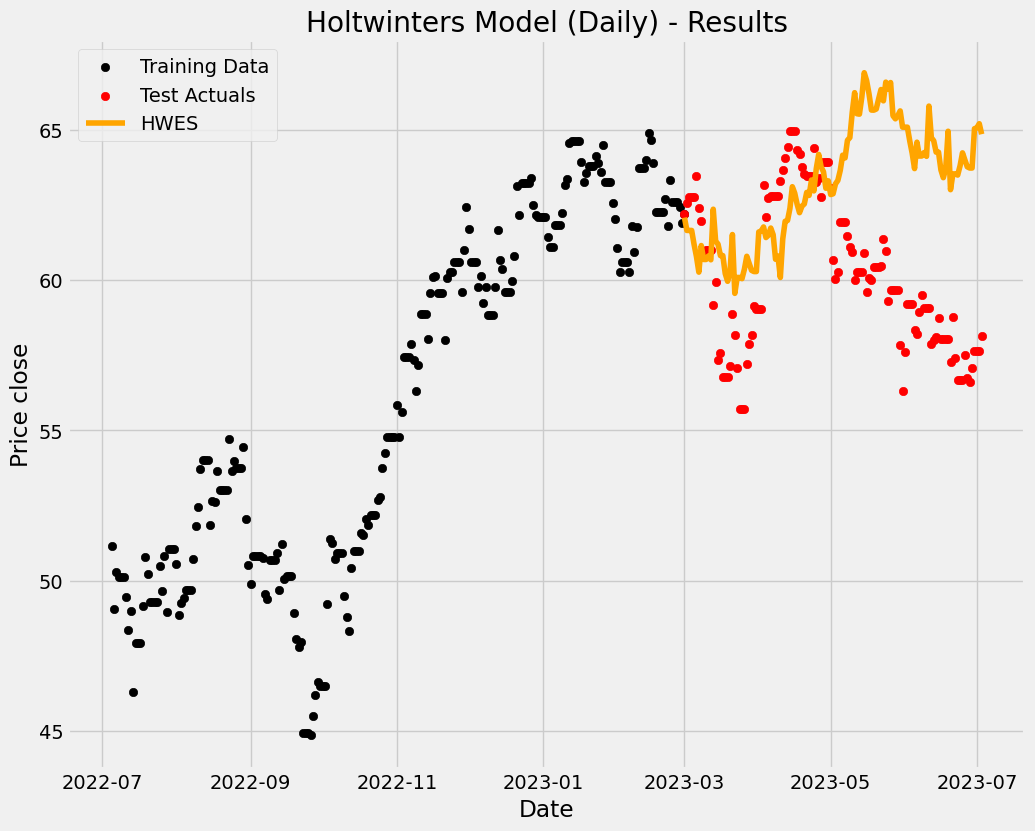

In [23]:
# Let's visually see the results
plt.scatter(x=train.index, y=train['Close'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['Close'], label='Test Actuals', color='red')
plt.plot(Electrostock_prediction['Close'], label='HWES', color='orange')

# Plot Labels, Legends etc
plt.xlabel("Date")
plt.ylabel("Price close")
plt.legend(loc='best')
plt.title('Holtwinters Model (Daily) - Results')


plt.show()

## XGBoost

XGBoost - Aprendizaje en conjunto

XGBoost ha ganado popularidad recientemente debido a su habilidad para predecir diversos tipos de problemas con gran eficacia.

Normalmente, con modelos de árboles de decisión, se tomarían los datos y se crearía un solo árbol para ellos. Sin embargo, esto puede llevar a un sobreajuste y confusión debido a las tendencias únicas de los datos pasados.

Para superar esto, se utiliza el "reforzamiento de gradientes" (gradient boosting). A grandes rasgos, este proceso es análogo a que el algoritmo cree un árbol de decisión para intentar predecir el resultado, luego descubra qué tan incorrecto fue y cree otro árbol que aprenda de los "errores" del primero.

Este proceso se repite varias veces, cientos o incluso miles de veces, con cada árbol siendo "impulsado" por los errores del anterior. El algoritmo continúa hasta que deja de mejorar su desempeño.


Ingeniería de características

Como se mencionó anteriormente, la mayoría de los modelos de aprendizaje automático no "miran hacia atrás" a los valores anteriores. Esencialmente, si tienes una tabla, cada "fila" es un punto de datos independiente y el modelo de aprendizaje automático no considera los datos de la fila anterior.

Esto es problemático para los datos de series temporales, como se muestra arriba, donde ocurre la autocorrelación.

Para abordar este problema, utilizamos la ingeniería de características para crear características adicionales; en este caso, he creado 365 columnas adicionales para cada día anterior. Hoy menos 1 día, Hoy menos 2 días... hasta Hoy menos 365 días.

In [24]:
# Feature Engineering first

def preprocess_xgb_data(df, lag_start=1, lag_end=365):
    '''
    Takes data and preprocesses for XGBoost.
    
    :param lag_start default 1 : int
        Lag window start - 1 indicates one-day behind
    :param lag_end default 365 : int
        Lag window start - 365 indicates one-year behind
        
    Returns tuple : (data, target)
    '''
    # Default is add in lag of 365 days of data - ie make the model consider 365 days of prior data
    for i in range(lag_start,lag_end):
        df[f'Close {i}'] = df.shift(periods=i, freq='D')['Close']

    df.reset_index(inplace=True)

    # Split out attributes of timestamp - hopefully this lets the algorithm consider seasonality
    df['date_epoch'] = pd.to_numeric(df['Date']) # Easier for algorithm to consider consecutive integers, rather than timestamps
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['dayofmonth'] = df['Date'].dt.day
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['weekofyear'] = df['Date'].dt.weekofyear
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    
    x = df.drop(columns=['Date', 'Close']) #Don't need timestamp and target
    y = df['Close'] # Target prediction is the load
    
    return x, y

In [25]:
example_data = train.copy() #Otherwise it becomes a pointer

example_x, example_y = preprocess_xgb_data(example_data)

example_x.head(10)

/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/953950725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Close {i}'] = df.shift(periods=i, freq='D')['Close']
/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/953950725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Close {i}'] = df.shift(periods=i, freq='D')['Close']
/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/953950725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

,Close 1,Close 2,Close 3,Close 4,Close 5,Close 6,Close 7,Close 8,Close 9,Close 10,...,Close 363,Close 364,date_epoch,dayofweek,dayofmonth,dayofyear,weekofyear,quarter,month,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1656979200000000000,1,5,186,27,3,7,2022
1,51.150002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1657065600000000000,2,6,187,27,3,7,2022
2,49.060001,51.150002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1657152000000000000,3,7,188,27,3,7,2022
3,50.279999,49.060001,51.150002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1657238400000000000,4,8,189,27,3,7,2022
4,50.130001,50.279999,49.060001,51.150002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1657324800000000000,5,9,190,27,3,7,2022
5,50.130001,50.130001,50.279999,49.060001,51.150002,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1657411200000000000,6,10,191,27,3,7,2022
6,50.130001,50.130001,50.130001,50.279999,49.060001,51.150002,NaN,NaN,NaN,NaN,...,NaN,NaN,1657497600000000000,0,11,192,28,3,7,2022
7,49.450001,50.130001,50.130001,50.130001,50.279999,49.060001,51.150002,NaN,NaN,NaN,...,NaN,NaN,1657584000000000000,1,12,193,28,3,7,2022
8,48.349998,49.450001,50.130001,50.130001,50.130001,50.279999,49.060001,51.150002,NaN,NaN,...,NaN,NaN,1657670400000000000,2,13,194,28,3,7,2022
9,48.980000,48.349998,49.450001,50.130001,50.130001,50.130001,50.279999,49.060001,51.150002,NaN,...,NaN,NaN,1657756800000000000,3,14,195,28,3,7,2022


Ahora necesitamos dividir la serie de tiempo entre entrenamiento y prueba, como lo hicimos antes.

La validación cruzada es más complicada en este caso, ya que los conjuntos de datos deben ser secuenciales.

También necesitaremos especificar características y etiquetas (es decir, el objetivo que queremos predecir).

In [26]:
xtrain = train.copy() #Otherwise it becomes a pointer
xtest = test.copy() # Otherwise it becomes a pointer

train_feature, train_label = preprocess_xgb_data(xtrain)
test_feature, test_label = preprocess_xgb_data(xtest)

/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/953950725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Close {i}'] = df.shift(periods=i, freq='D')['Close']
/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/953950725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Close {i}'] = df.shift(periods=i, freq='D')['Close']
/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/953950725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

Finalmente, entrenamos el modelo y vemos qué tan bien se desempeñó (usando el MAE) y visualizamos los resultados.

Para entrenar el modelo, nuevamente dividí los datos en dos partes: entrenamiento desde inicio 2022-07-5 hasta 2023-02-01  y evaluación/prueba desde 2023-02-02 hasta 2024.

En este caso, utilicé 300 iteraciones y una profundidad máxima de cada árbol de 6. Es decir, realiza 300 iteraciones (o menos si deja de mejorar), y cada árbol tiene un máximo de 6 niveles.

Siendo un algoritmo basado en árboles, generalmente XGBoost no maneja bien las tendencias en los datos en comparación con los modelos lineales. Sin embargo, como se muestra arriba en la prueba ADF, los datos son estacionarios, por lo que la tendencia no es realmente un problema y podemos proceder. De lo contrario, tendríamos que eliminar la tendencia de los datos como parte del preprocesamiento.

In [27]:
#Train and predict using XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split

# We will try with 1000 trees and a maximum depth of each tree to be 5
# Early stop if the model hasn't improved in 100 rounds
model = XGBRegressor(
    max_depth=6 # Default - 6
    ,n_estimators=300
    ,booster='gbtree'
    ,colsample_bytree=1 # Subsample ratio of columns when constructing each tree - default 1
    ,eta=0.3 # Learning Rate - default 0.3
    ,importance_type='weight' # Default is gain
)
model.fit(
    train_feature
    ,train_label
    ,eval_set=[(train_feature, train_label)]
    ,eval_metric='mae'
    ,verbose=True
    ,early_stopping_rounds=50 # Stop after 100 rounds if it doesn't after 100 times
)

xtest['Electrostock_MW Prediction'] = model.predict(test_feature)
XGB_prediction = xtest[['Date', 'Electrostock_MW Prediction']].set_index('Date')

[0]	validation_0-mae:38.98528
[1]	validation_0-mae:27.38588
[2]	validation_0-mae:19.23622
[3]	validation_0-mae:13.53074
[4]	validation_0-mae:9.51963
[5]	validation_0-mae:6.70411
[6]	validation_0-mae:4.71429
[7]	validation_0-mae:3.32871
[8]	validation_0-mae:2.35833
[9]	validation_0-mae:1.67941
[10]	validation_0-mae:1.19919
[11]	validation_0-mae:0.86076
[12]	validation_0-mae:0.63033
[13]	validation_0-mae:0.45991
[14]	validation_0-mae:0.34390
[15]	validation_0-mae:0.26536
[16]	validation_0-mae:0.21556
[17]	validation_0-mae:0.17181
[18]	validation_0-mae:0.14194
[19]	validation_0-mae:0.11956
[20]	validation_0-mae:0.10409
[21]	validation_0-mae:0.09800
[22]	validation_0-mae:0.09139
[23]	validation_0-mae:0.08376
[24]	validation_0-mae:0.07291
[25]	validation_0-mae:0.06850
[26]	validation_0-mae:0.06011
[27]	validation_0-mae:0.05439
[28]	validation_0-mae:0.05078
[29]	validation_0-mae:0.04636
[30]	validation_0-mae:0.04253
[31]	validation_0-mae:0.03984
[32]	validation_0-mae:0.03634
[33]	validation_

/Users/leidygarciaguzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/leidygarciaguzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-mae:0.02130
[39]	validation_0-mae:0.02034
[40]	validation_0-mae:0.01967
[41]	validation_0-mae:0.01828
[42]	validation_0-mae:0.01629
[43]	validation_0-mae:0.01535
[44]	validation_0-mae:0.01432
[45]	validation_0-mae:0.01370
[46]	validation_0-mae:0.01296
[47]	validation_0-mae:0.01216
[48]	validation_0-mae:0.01112
[49]	validation_0-mae:0.01066
[50]	validation_0-mae:0.01001
[51]	validation_0-mae:0.00957
[52]	validation_0-mae:0.00873
[53]	validation_0-mae:0.00817
[54]	validation_0-mae:0.00784
[55]	validation_0-mae:0.00746
[56]	validation_0-mae:0.00689
[57]	validation_0-mae:0.00638
[58]	validation_0-mae:0.00614
[59]	validation_0-mae:0.00590
[60]	validation_0-mae:0.00566
[61]	validation_0-mae:0.00524
[62]	validation_0-mae:0.00467
[63]	validation_0-mae:0.00444
[64]	validation_0-mae:0.00427
[65]	validation_0-mae:0.00399
[66]	validation_0-mae:0.00385
[67]	validation_0-mae:0.00350
[68]	validation_0-mae:0.00334
[69]	validation_0-mae:0.00318
[70]	validation_0-mae:0.00289
[71]	valid

/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/78411928.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  xtest['Electrostock_MW Prediction'] = model.predict(test_feature)


In [28]:
from sklearn.metrics import mean_absolute_error

print("MAE XGB: {:.20f}".format(mean_absolute_error(test_label, XGB_prediction['Electrostock_MW Prediction'])))

MAE XGB: 2.40670549876562622771


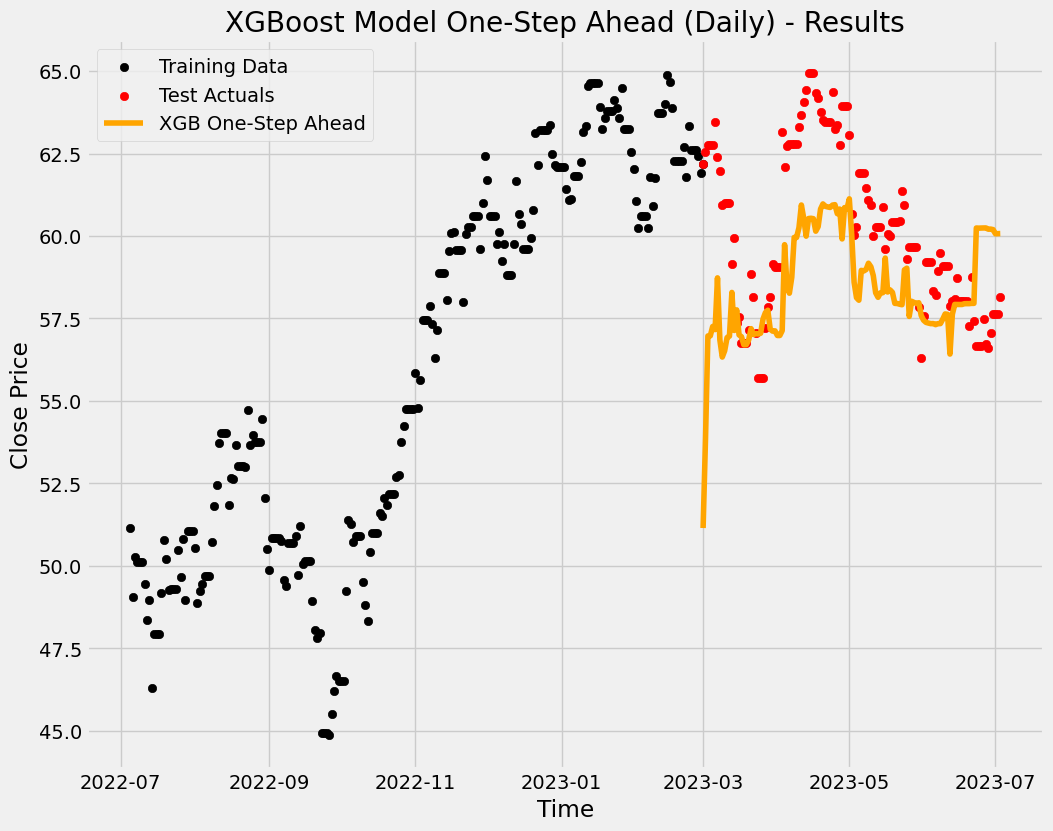

In [29]:
# Let's visually see the results
plt.scatter(x=train.index, y=train['Close'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['Close'], label='Test Actuals', color='red')
plt.plot(XGB_prediction, label='XGB One-Step Ahead', color='orange')

# Plot Labels, Legends etc
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend(loc='best')
plt.title('XGBoost Model One-Step Ahead (Daily) - Results')


plt.show()


¡Los resultados del modelo NO son  precisos!

Una advertencia es que el modelo conoce el valor de ayer. Por lo tanto, el "horizonte de pronóstico" (es decir, la longitud máxima de tiempo que puede predecir en el futuro) es solo de 1 día. Esto también se conoce como un "Pronóstico a un Paso Adelante".

Si solo tienes el valor de ayer, solo puedes predecir el valor de hoy. Si solo tienes el valor de hoy, solo puedes predecir el valor de mañana.

Ahora veamos qué consideró el algoritmo como más importante: tomaremos las 10 características principales según su peso.

El peso es el porcentaje que representa el número relativo de veces que ocurre una característica particular en los árboles del modelo. Es una manera aproximada de decir que cuanto más veces se hace referencia a una característica particular, más probable es que sea importante.

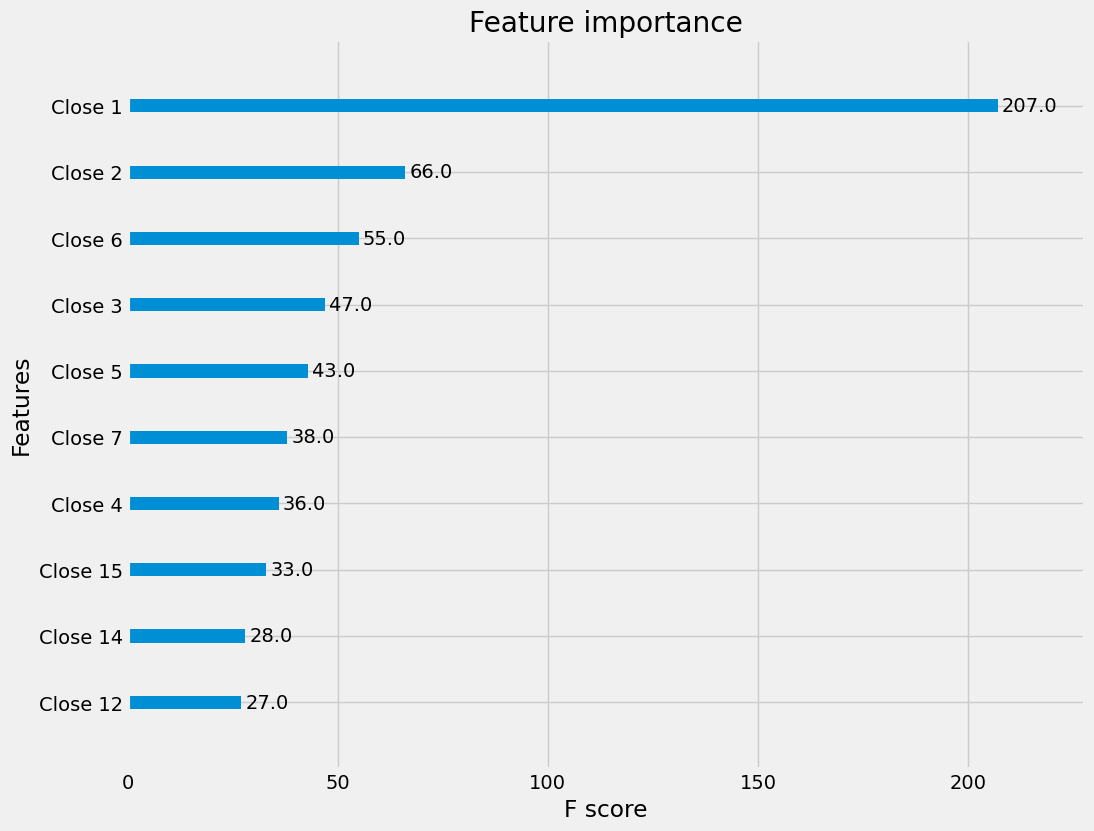

In [30]:
import xgboost as xgb

xgb.plot_importance(model, max_num_features=10, importance_type='weight') # "weight” is the number of times a feature appears in a tree

plt.show()


¡Parece que el valor de ayer es el factor más importante para determinar el valor de hoy! Esto, nuevamente, tiene sentido, dado que la función de autocorrelación mostró que el valor de ayer tenía la mayor correlación con el valor de hoy.

Un enfoque alternativo de ingeniería de características: incluyamos rezagos (lags) sin filtración de datos.

Intentemos hacer que el modelo XGBoost sea más que una predicción de un solo paso - solo incluiremos la ingeniería de características para:

Día de la semana
Día del mes
Día del año
Semana del año
Mes
Año
Con suerte, esto será suficiente para que el modelo capte artificialmente factores de "estacionalidad" - por ejemplo, si el mismo día de la semana, podría estar correlacionado.

 NO--Sin embargo, como el horizonte de pronóstico es de 365 días, todavía podemos incluir datos de rezagos de 365 a 720 días (es decir, datos del año anterior al año anterior).

In [31]:
# So because we need the lag data, we need to preprocess then do the split
all_data = daily_data.copy()

feature, label = preprocess_xgb_data(all_data, lag_start=365, lag_end=720)

# We will aim for a 12 month forecast horizon (ie predict the last 365 days in the dataset)
train_feature = feature[:-200]
train_label = label[:-200]

test_feature = feature[-125:]
test_label = label[-125:]

/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/953950725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Close {i}'] = df.shift(periods=i, freq='D')['Close']
/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/953950725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Close {i}'] = df.shift(periods=i, freq='D')['Close']
/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/953950725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

In [32]:
#Train and predict using XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split


model = XGBRegressor(
    max_depth=5 # Default - 5
    ,n_estimators=500
    ,booster='gbtree'
    ,colsample_bytree=1 # Subsample ratio of columns when constructing each tree - default 1
    ,eta=0.1 # Learning Rate - default 0.1
    ,importance_type='gain' # Default is gain
)
model.fit(
    train_feature
    ,train_label
    ,eval_set=[(train_feature, train_label)]
    ,eval_metric='mae'
    ,verbose=True
    ,early_stopping_rounds=40 
)

xtest['Electrostock_MW Prediction'] = model.predict(test_feature)
XGB_prediction_no_lag = xtest[['Date', 'Electrostock_MW Prediction']].set_index('Date')
XGB_prediction_no_lag = XGB_prediction_no_lag.rename(columns={'Electrostock_MW Prediction': 'Close'})

[0]	validation_0-mae:47.23832
[1]	validation_0-mae:42.54312
[2]	validation_0-mae:38.34189
[3]	validation_0-mae:34.55550
[4]	validation_0-mae:31.14339


[5]	validation_0-mae:28.06800
[6]	validation_0-mae:25.29669
[7]	validation_0-mae:22.79852
[8]	validation_0-mae:20.54754
[9]	validation_0-mae:18.51882
[10]	validation_0-mae:16.68989
[11]	validation_0-mae:15.04235
[12]	validation_0-mae:13.55684
[13]	validation_0-mae:12.21863
[14]	validation_0-mae:11.01233
[15]	validation_0-mae:9.93356
[16]	validation_0-mae:8.95307
[17]	validation_0-mae:8.06937
[18]	validation_0-mae:7.28862
[19]	validation_0-mae:6.56933
[20]	validation_0-mae:5.93541
[21]	validation_0-mae:5.36427


/Users/leidygarciaguzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/leidygarciaguzman/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-mae:4.84860
[23]	validation_0-mae:4.38337
[24]	validation_0-mae:3.96340
[25]	validation_0-mae:3.58203
[26]	validation_0-mae:3.23767
[27]	validation_0-mae:2.92796
[28]	validation_0-mae:2.64787
[29]	validation_0-mae:2.39584
[30]	validation_0-mae:2.17128
[31]	validation_0-mae:1.97179
[32]	validation_0-mae:1.78722
[33]	validation_0-mae:1.62430
[34]	validation_0-mae:1.47933
[35]	validation_0-mae:1.34703
[36]	validation_0-mae:1.22794
[37]	validation_0-mae:1.12037
[38]	validation_0-mae:1.02486
[39]	validation_0-mae:0.93691
[40]	validation_0-mae:0.86085
[41]	validation_0-mae:0.79197
[42]	validation_0-mae:0.72950
[43]	validation_0-mae:0.67493
[44]	validation_0-mae:0.62353
[45]	validation_0-mae:0.57623
[46]	validation_0-mae:0.53730
[47]	validation_0-mae:0.50218
[48]	validation_0-mae:0.47440
[49]	validation_0-mae:0.44863
[50]	validation_0-mae:0.42710
[51]	validation_0-mae:0.40319
[52]	validation_0-mae:0.38517
[53]	validation_0-mae:0.36516
[54]	validation_0-mae:0.34874
[55]	valid

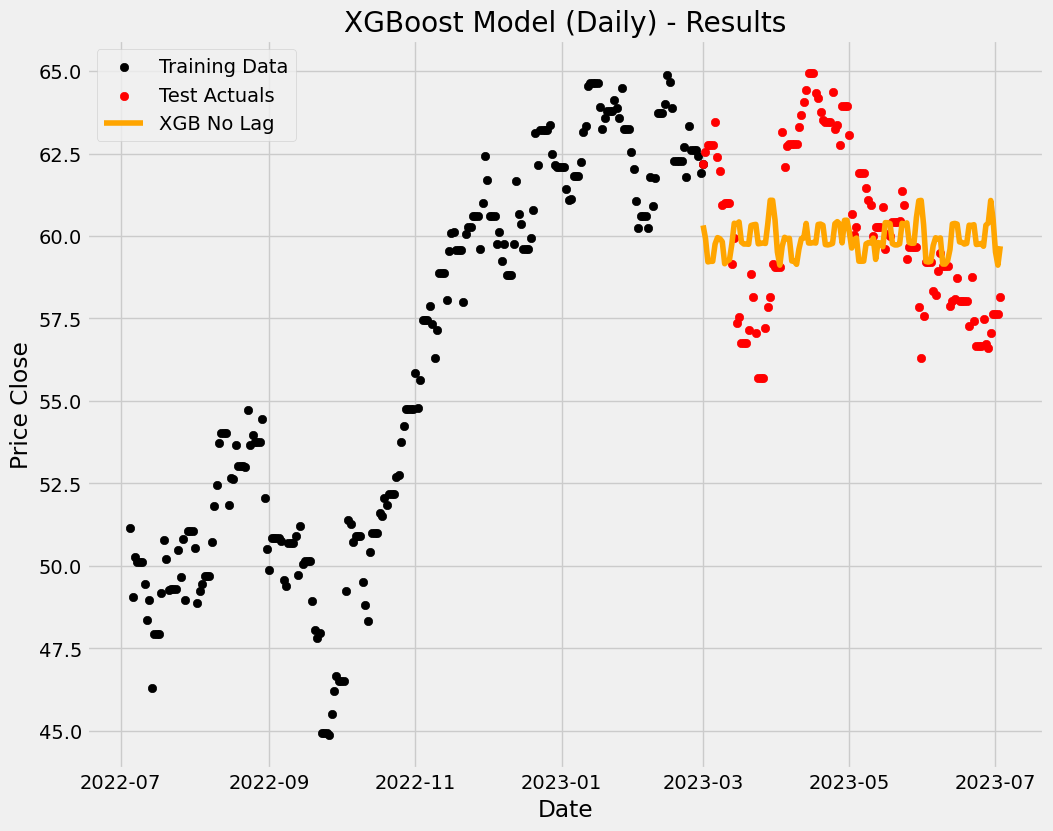

In [33]:
# Let's visually see the results
plt.scatter(x=train.index, y=train['Close'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['Close'], label='Test Actuals', color='red')
plt.plot(XGB_prediction_no_lag, label='XGB No Lag', color='orange')

# Plot Labels, Legends etc
plt.xlabel("Date")
plt.ylabel("Price Close")
plt.legend(loc='best')
plt.title('XGBoost Model (Daily) - Results')


plt.show()

No hace falta hacer un lag en este modelo. porque ya en el anterior bajo el MAE a cero rapidamente. 

Ahora echemos un vistazo a los residuos o errores.

Primero, observemos la distribución de los errores. Recuerda que el estado ideal es que los errores estén centrados alrededor de cero (lo que significa que el modelo no pronostica sistemáticamente por encima o por debajo en una dirección sesgada).

In [34]:
# First construct the residuals - basically the errors
xgboost_errors = XGB_prediction_no_lag.copy()
xgboost_errors['Electrostock_MW_ACTUAL'] = test.copy()
xgboost_errors['error'] = xgboost_errors['Close'] - xgboost_errors['Electrostock_MW_ACTUAL']

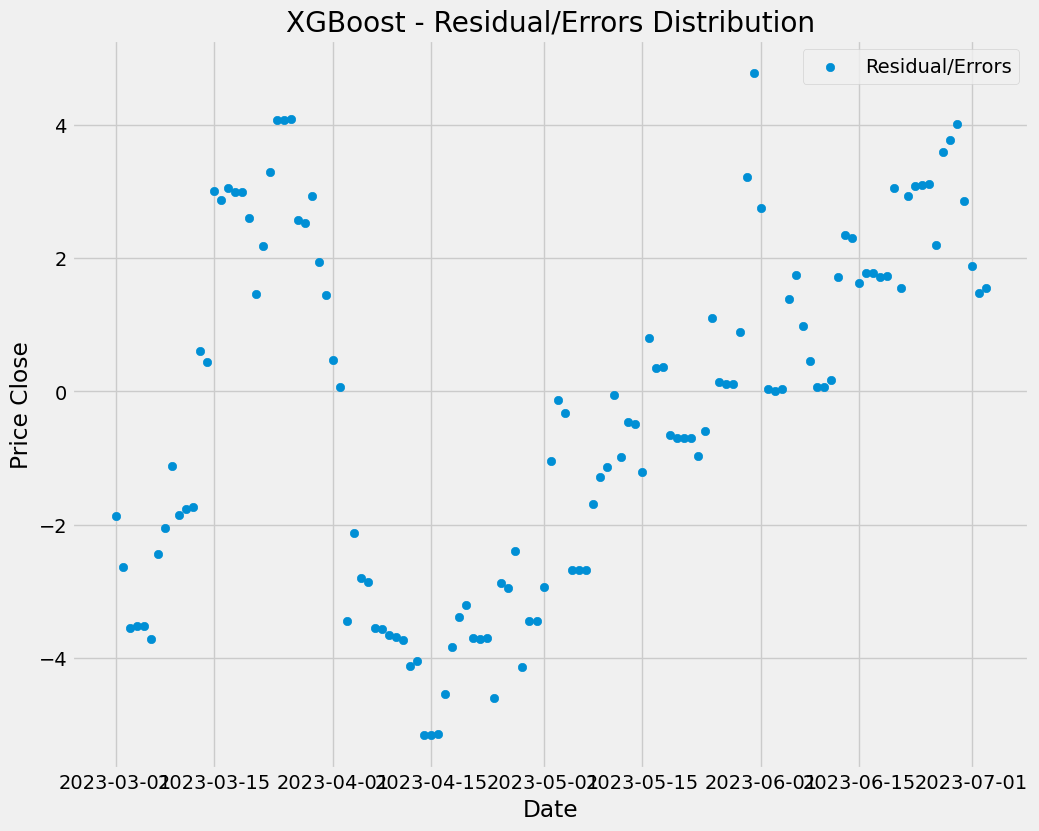

In [35]:
# Let's visually see the errors via scatterplot
plt.scatter(xgboost_errors.index, xgboost_errors['error'], label='Residual/Errors')

# Plot Labels, Legends etc
plt.title('XGBoost - Residual/Errors Distribution')
plt.xlabel("Date")
plt.ylabel("Price Close")
plt.legend(loc='best')

plt.show()

/Users/leidygarciaguzman/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'XGBoost - Residual/Errors Distribution')

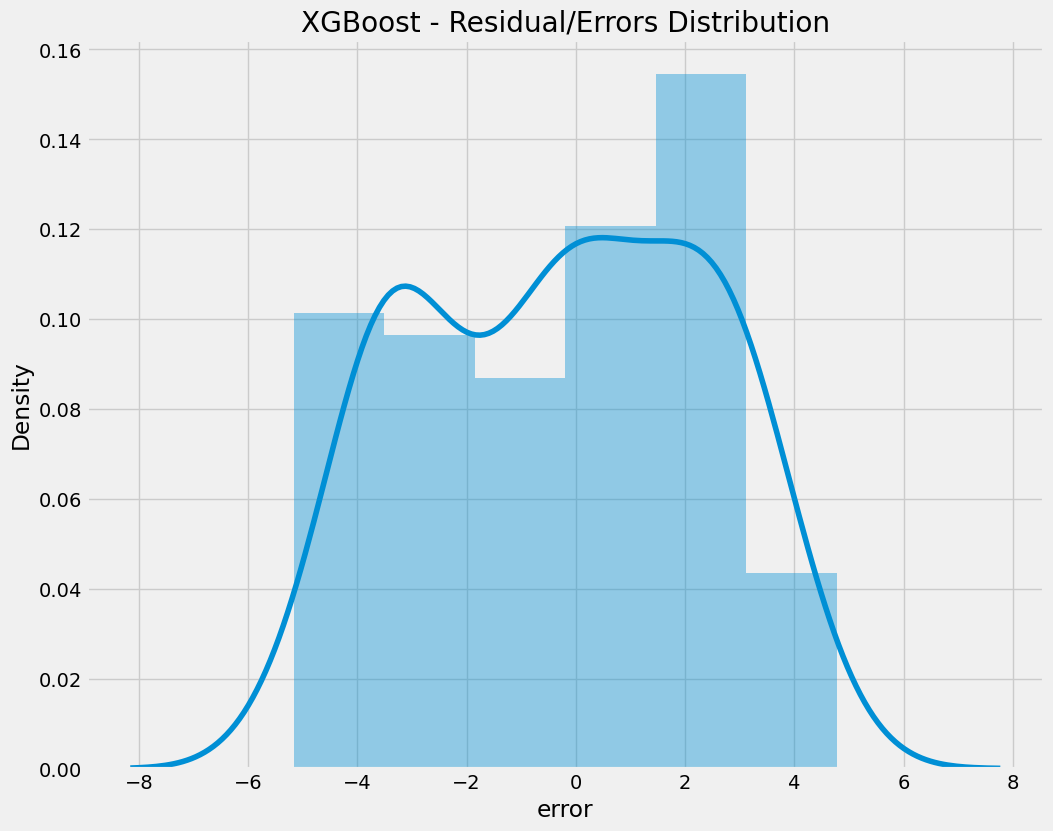

In [36]:
# Plot Histogram with Kernel Density Estimation (KDE)
sns.distplot(xgboost_errors['error'], kde=True);

# Plot Labels, Legends etc
plt.title('XGBoost - Residual/Errors Distribution')

No tiene distribución uniforme, 

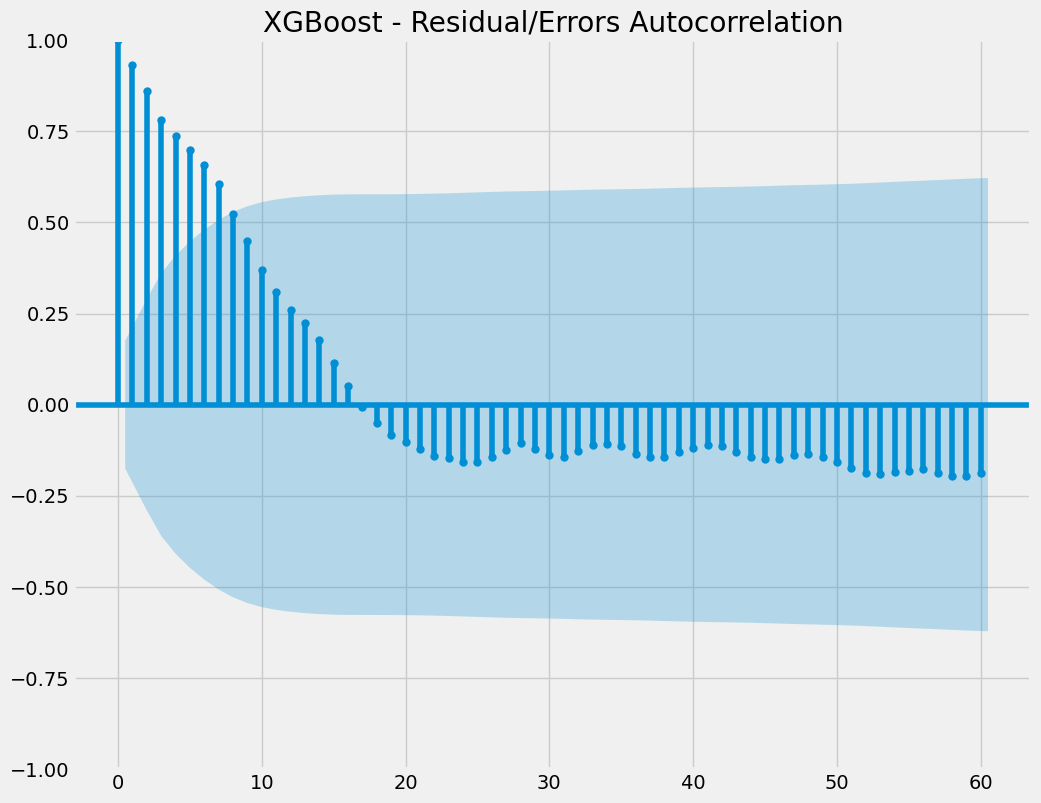

In [37]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the acf function
plot_acf(xgboost_errors['error'],lags=60)

plt.title('XGBoost - Residual/Errors Autocorrelation')
plt.show()

La mayoría de los puntos están dentro de la sombra azul (es decir, el intervalo de confianza), lo que indica que no hay autocorrelación estadísticamente significativa en los errores. Esto es positivo, ya que si hubiera autocorrelación en nuestros errores, significaría que nuestro modelo no está capturando cierta autocorrelación presente en los datos.

# La regresión LASSO 

Incorpora regularización y selección de características en su algoritmo. La regularización es una técnica utilizada en algoritmos de regresión para evitar el sobreajuste. En el caso de LASSO, esto significa que penalizará las características "irrelevantes" efectivamente "anulándolas" (multiplicándolas con un coeficiente 0).

El principal hiperparámetro a ajustar es el factor de penalización (lambda o alpha). Un factor de 0 significa que no se produce penalización y, efectivamente, solo realiza una regresión de mínimos cuadrados ordinarios (OLS).

Dado que ya hemos configurado la división de entrenamiento-prueba (así como la ingeniería de características) en el modelo XGBoost anterior, simplemente podemos reutilizarlo.

Sin embargo, al igual que XGBoost basado en árboles de decisión, la regresión lineal es sensible a la escala de las características. Por lo tanto, también necesitamos escalar los datos.

In [38]:
# So because we need the lag data, we need to preprocess then do the split
all_data = daily_data.copy()

# Create train test dataset using XGBoost preprocessing (365 days top 720 days lag)
feature, label = preprocess_xgb_data(all_data, lag_start=365, lag_end=720)

# We will aim for a 12 month forecast horizon (ie predict the last 365 days in the dataset)
train_feature = feature[:-150]
train_label = label[:-150]

test_feature = feature[-125:]
test_label = label[-125:]

train_feature = train_feature.fillna(0)
test_feature = test_feature.fillna(0)

# train_feature.drop(columns=['date_epoch']) #Don't need timestamp
# test_feature.drop(columns=['date_epoch']) #Don't need timestamp

# Scale dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_feature_scaled = scaler.fit_transform(train_feature)
test_feature_scaled = scaler.transform(test_feature)

/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/953950725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Close {i}'] = df.shift(periods=i, freq='D')['Close']
/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/953950725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Close {i}'] = df.shift(periods=i, freq='D')['Close']
/var/folders/rl/7bt84j4j31gg1ssp767d9xgm0000gn/T/ipykernel_32420/953950725.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 


A continuación, entrenaremos el modelo utilizando el método de validación cruzada con división de series de tiempo de sklearn.

En este caso, crearemos una división en 5 partes.

In [39]:
# Create Time Series k-fold cross validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5) # in this case 5-fold

#Train and predict using LASSO
from sklearn.linear_model import LassoCV

model = LassoCV(
    alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,0.3, 0.6, 1]
    ,max_iter=700 # 700 iterations
    ,random_state=42
    ,cv=tscv
    ,verbose=True
)
model.fit(
    train_feature_scaled
    ,train_label
)
LASSO_prediction = xtest.copy()
LASSO_prediction['Electrostock_MW Prediction'] = model.predict(test_feature_scaled)
LASSO_prediction = LASSO_prediction[['Date', 'Electrostock_MW Prediction']].set_index('Date')
LASSO_prediction = LASSO_prediction.rename(columns={'Electrostock_MW Prediction': 'Close'})

LASSO_prediction

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
............................................................/Users/leidygarciaguzman/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.923e+00, tolerance: 4.334e-01
  model = cd_fast.enet_coordinate_descent(
./Users/leidygarciaguzman/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.885e+02, tolerance: 4.334e-01
  model = cd_fast.enet_coordinate_descent(
./Users/leidygarciaguzman/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

,Close
Date,
2023-03-01,65.756984
2023-03-02,65.838164
2023-03-03,65.919343
2023-03-04,66.000523
2023-03-05,66.081702
...,...
2023-06-29,74.860162
2023-06-30,74.941342
2023-07-01,74.814355


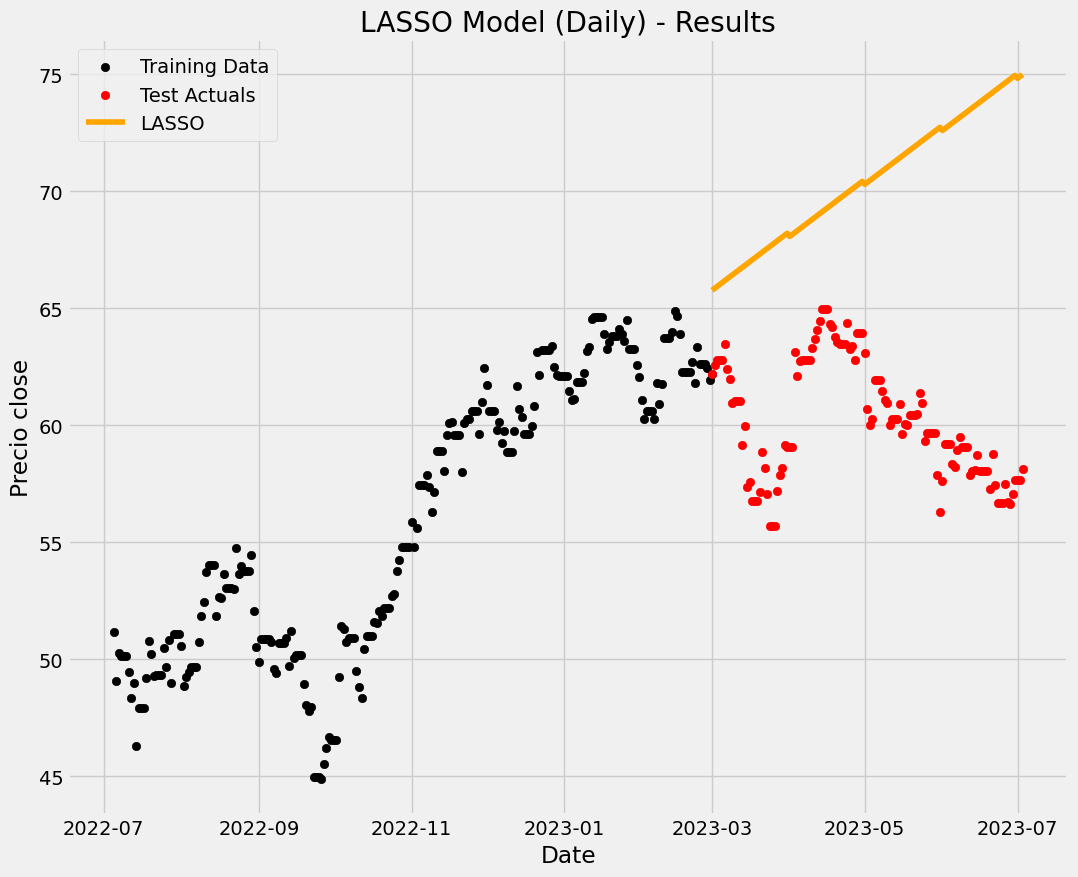

In [40]:
# Let's visually see the results
plt.scatter(x=train.index, y=train['Close'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['Close'], label='Test Actuals', color='red')
plt.plot(LASSO_prediction, label='LASSO', color='orange')

# Plot Labels, Legends etc
plt.xlabel("Date")
plt.ylabel("Precio close")
plt.legend(loc='best')
plt.title('LASSO Model (Daily) - Results')
plt.tight_layout()
plt.grid(True)
        

plt.show()


A continuación, veamos la importancia de las características a través de los coeficientes; solo obtendremos las 10 principales.

Recuerda que LASSO "anula" las características irrelevantes, por lo que en este caso, estas son las 10 características principales que LASSO considera más importantes.

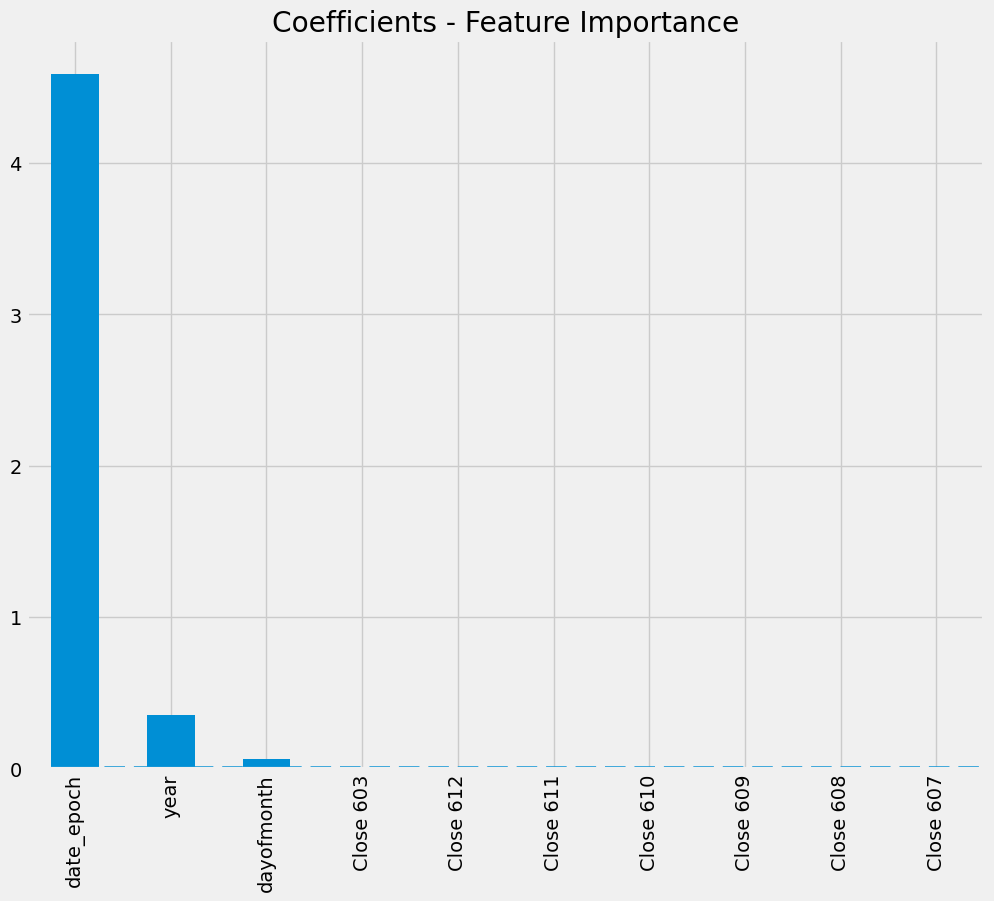

In [41]:
# Plot feature importance by way of coefficients    

# Create DataFrame
coefs = pd.DataFrame(model.coef_, train_feature.columns)
coefs.columns = ["coef"]

# Only grab the Top 10 Coefficients
coefs["abs"] = coefs.coef.apply(np.abs)
coefs = coefs.sort_values(by="abs", ascending=False).head(10)
coefs = coefs.drop(["abs"], axis=1)

# Plot
coefs.coef.plot(kind='bar')

# Plot title and x-axis line
plt.title("Coefficients - Feature Importance")
plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [42]:
# First construct the residuals - basically the errors
lasso_errors = LASSO_prediction.copy()
lasso_errors['Electrostock_MW_ACTUAL'] = test.copy()
lasso_errors['error'] = lasso_errors['Close'] - lasso_errors['Electrostock_MW_ACTUAL']

/Users/leidygarciaguzman/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


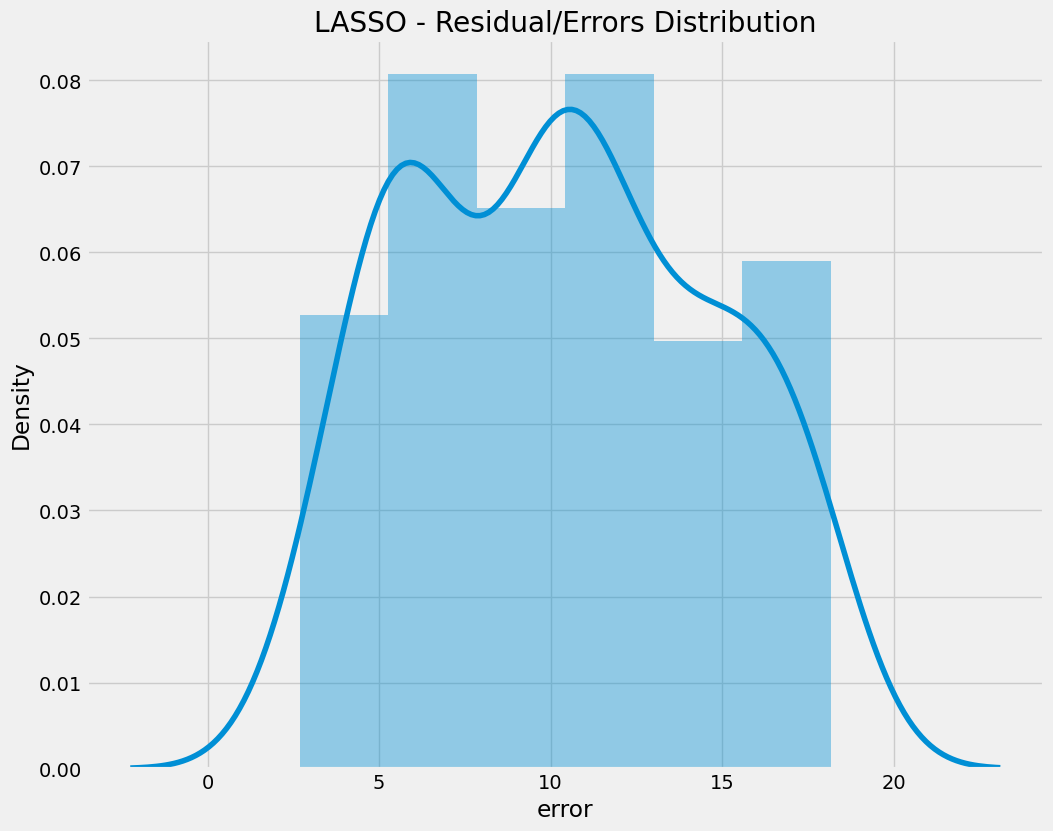

In [43]:
# Plot Histogram with Kernel Density Estimation (KDE)
sns.distplot(lasso_errors['error'], kde=True)

# Plot Labels, Legends etc
plt.title('LASSO - Residual/Errors Distribution')

plt.show()

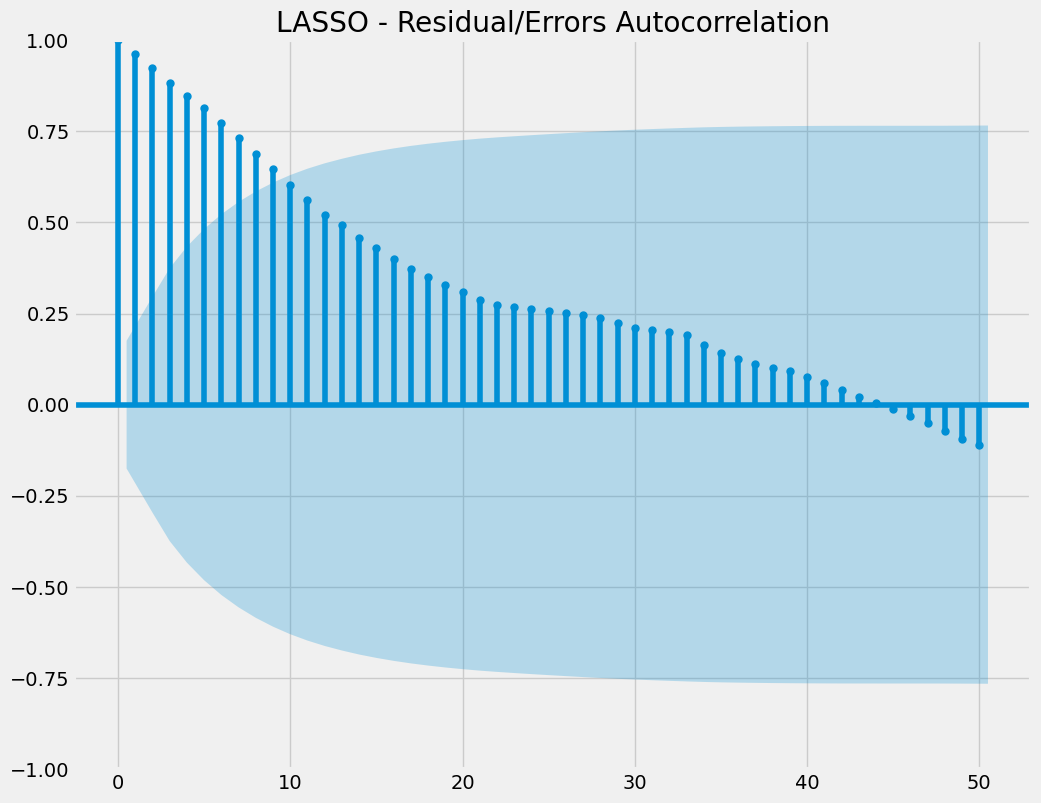

In [44]:
# Plot the acf function
plot_acf(lasso_errors['error'],lags=50) #alpha 1 suppresses CI

plt.title('LASSO - Residual/Errors Autocorrelation')
plt.show()

# SARIMA

El modelo ARIMA convencional asume que los datos históricos son útiles para predecir el valor en el próximo paso de tiempo. En este caso, esto es en cierta medida cierto, ya que el gráfico ACF anterior mostró que el valor pasado está algo correlacionado con el valor actual.

ARIMA básicamente integra dos técnicas de pronóstico ingenuas:

Autoregresión - Utiliza uno o más valores pasados para pronosticar el futuro. El número de valores utilizados se conoce como "orden" (por ejemplo, orden 2 significa que se utilizan los valores de ayer y el día anterior).

Integración - la parte que reduce la estacionalidad. El número de grados de diferenciación que se realiza para reducir la estacionalidad es el "orden".

Media móvil - Utiliza el promedio móvil de los datos históricos para ajustar los valores pronosticados. Esto tiene un efecto de "suavizado" en los datos pasados, ya que utiliza el promedio móvil en lugar de los valores reales del pasado. El número de días en la ventana de promedio móvil es el "orden".

SARIMA agrega un "sabor" de "estacionalidad" al modelo ARIMA, es decir, tiene en cuenta las tendencias y la estacionalidad, como se explicó anteriormente.

Los principales hiperparámetros son SARIMAX(p, d, q) (P, D, Q, m):

Orden de autoregresión (p)
Orden de integración (d)
Ventana de promedio móvil (q)
Orden autoregresivo estacional (P)
Orden de diferencia estacional (D)
Orden de media móvil estacional (Q)
Número de pasos de tiempo para un período estacional único (m)
La "X" se refiere a las variables exógenas (externas) del modelo, que son opcionales y en este modelo no las utilizaremos.

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import meanabs

# Equivalent to R's Auto ARIMA to get the optimal parameters
#import pmdarima as pm
#model = pm.auto_arima(htrain, seasonal=True, stationary=True, stepwise=True, trace=True, suppress_warnings=True)

# First we split it up between train and test
htrain = train['Close'] # SARIMAX takes series, not DF
htest = test['Close'] # SARIMAX takes series, not DF

# Next define hyperparameters. Default is AR model (1,0,0)(0,0,0,0)
p = 0 # AR order
d = 1 # I degree
q = 0 # MA window
P = 0 # AR seasonal order
D = 0 # I seasonal order
Q = 0 # MA seasonal order
m = 7 # Seasonality period length

model = SARIMAX(
    htrain,
    order=(p, d, q),
    seasonal_order=(P, D, Q, m)
    ,enforce_stationarity=False
    ,enforce_invertibility=False
).fit(
    maxiter=50 # Default is 50
)

results = model.get_prediction(start=htest.index[0], end=htest.index[-1], dynamic=False)
SARIMA_prediction_CI = results.conf_int(alpha=(1-0.8)) # 80% CI
SARIMA_prediction = results.predicted_mean
SARIMA_prediction = SARIMA_prediction.to_frame().assign(Close=SARIMA_prediction)
#rename(columns={0: 'Close'})
# Evaluate it's performance using Mean Absolute Error (MAE)
print("Finished training and predicting. MAE SARIMA: {:.20f}. AIC: {}. Parameters: p,d,q,P,D,Q,m: ".format(meanabs(htest, SARIMA_prediction['Close']), model.aic), p,d,q,P,D,Q,m)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25459D+00    |proj g|=  1.85524D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   8.033D-06   1.255D+00
  F =   1.2545275472976252     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Finished training and predicting. MAE SARIMA: 2.71359959200000044888. AIC: 604.1732227028601. Parameters: p,d,q,P,D,Q,m:  0 1 0 0 0 0 7


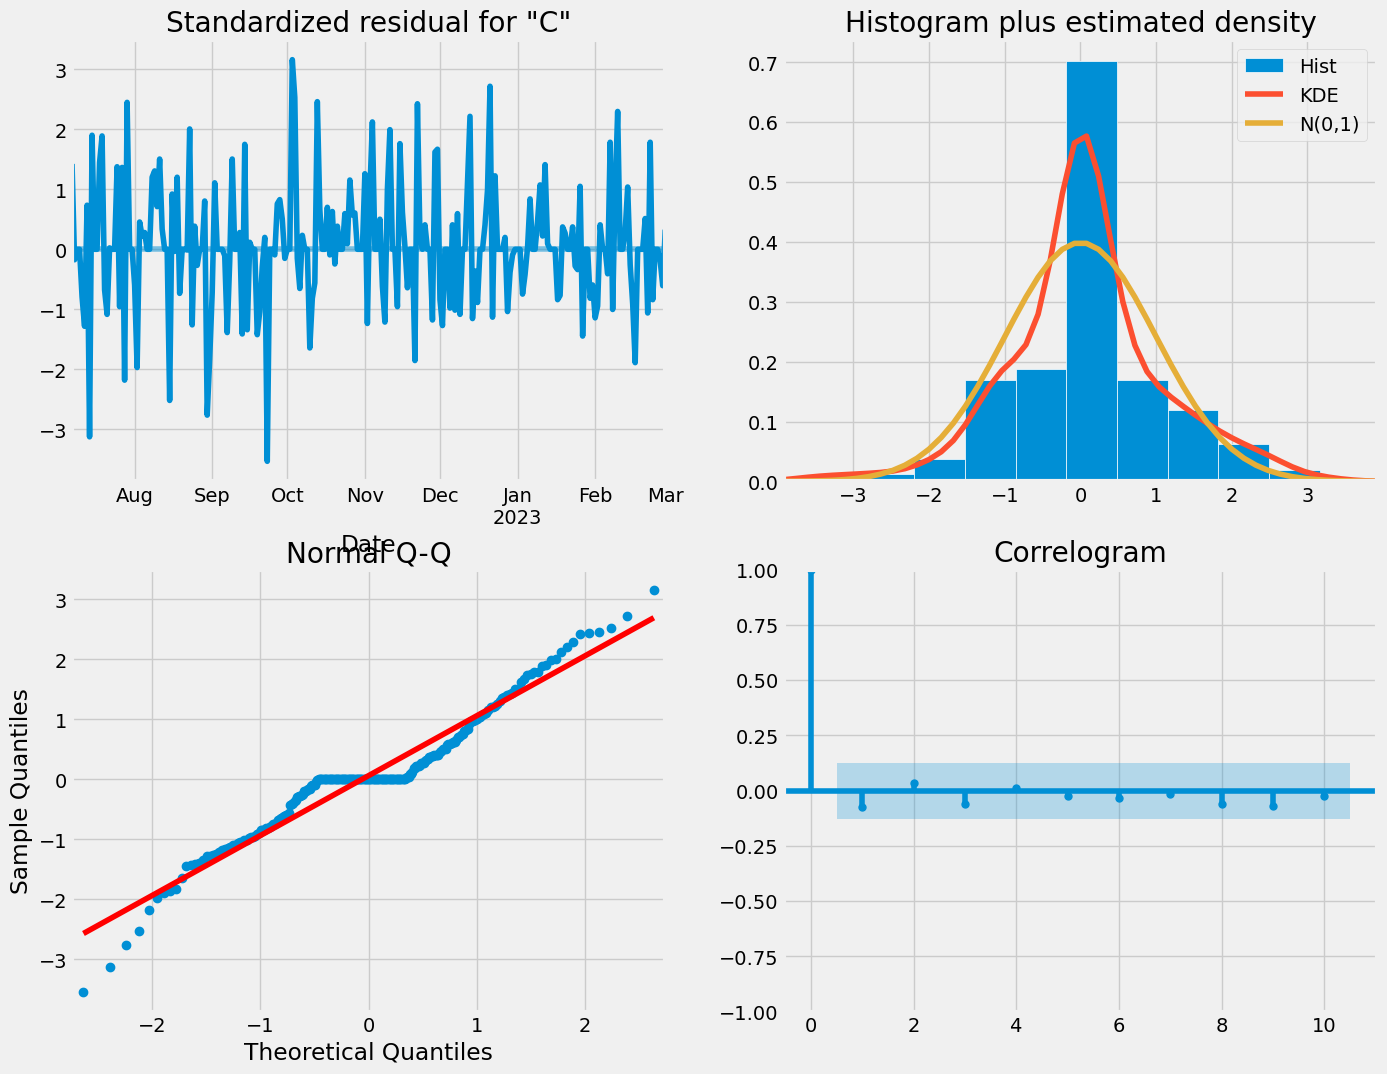

In [46]:
# Let's see what the model did
model.plot_diagnostics(figsize=(15, 12))
plt.show()


Es importante que los residuos del modelo estén descorrelacionados y distribuidos de manera normal (es decir, que la media sea cero). Es decir, el punto central de los residuos debería ser cero y el gráfico de distribución (KDE) también debería estar centrado en 0.

Vamos a evaluar los resultados y visualizarlos.

In [47]:
# Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE SARIMA: {:.20f}".format(meanabs(htest, SARIMA_prediction['Close'])))

MAE SARIMA: 2.71359959200000044888


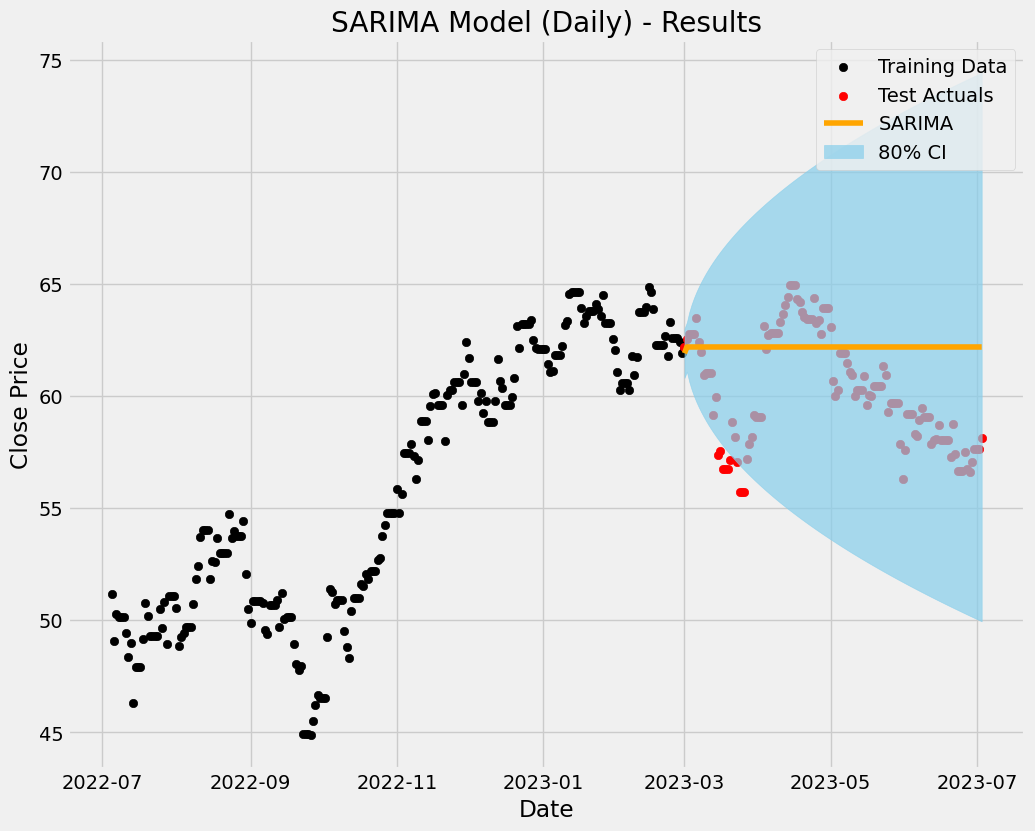

In [48]:
# Let's visually see the results
plt.scatter(x=train.index, y=train['Close'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['Close'], label='Test Actuals', color='red')
plt.plot(SARIMA_prediction['Close'], label='SARIMA', color='orange')

# Plot Confidence Interval
plt.fill_between(
    SARIMA_prediction.index,
    SARIMA_prediction_CI['lower Close'],
    SARIMA_prediction_CI['upper Close'],
    color='skyblue',
    alpha=0.7, # 70% transparency
    label='80% CI'
)

# Plot Labels, Legends etc
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='best')
plt.title('SARIMA Model (Daily) - Results')


plt.show()

Como puedes ver, a pesar de algunos ajustes, los resultados no son particularmente buenos. El intervalo de confianza es muy grande, lo que indica que el modelo no está "confiado" en la predicción.

# COMPARACIÓN DE LOS MODELOS Y RESULTADOS

In [49]:
def MAPE(y_true, y_pred): 
    '''Function to calculate MAPE'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [50]:

print("MAE HoltWinters: {:.2f}%".format(MAPE(test['Close'], HWES_prediction['Close'])))
print("MAE XGBoost: {:.2f}%".format(MAPE(test['Close'], XGB_prediction_no_lag['Close'])))
print("MAE LASSO: {:.2f}%".format(MAPE(test['Close'], LASSO_prediction['Close'])))
print("MAE SARIMA: {:.2f}%".format(MAPE(test['Close'], SARIMA_prediction['Close'])))


NameError: name 'HWES_prediction' is not defined

In [ ]:
def plot_model_result(ax, prediction, model_name, color):
    '''
    Plot model results.
    
    prediction : DataFrame
    model_name : str
    
    return ax
    '''
    # Training and Test Actuals
    ax.scatter(x=train.index, y=train['Close'], label='Training Data', color='black')
    ax.scatter(x=test.index, y=test['Close'], label='Test Actuals', color='red')

    # Model Results
    ax.plot(prediction['Close'], label=model_name, color=color, alpha=0.7)
    

    # Set Y Axis
    ax.set_ylim(500000, 1100000)
    
    # Set Axis labels
    ax.set_ylabel("Close Price")
    ax.legend(loc='best')
    ax.set_title(
        "{}: MAPE: {:.2f}% | MAE: {:.2f}".format(
            model_name,MAPE(test["Close"], prediction["Close"]),
            mean_absolute_error(test["Close"], prediction["Close"])
            )
        , fontsize=40
    )

    return ax

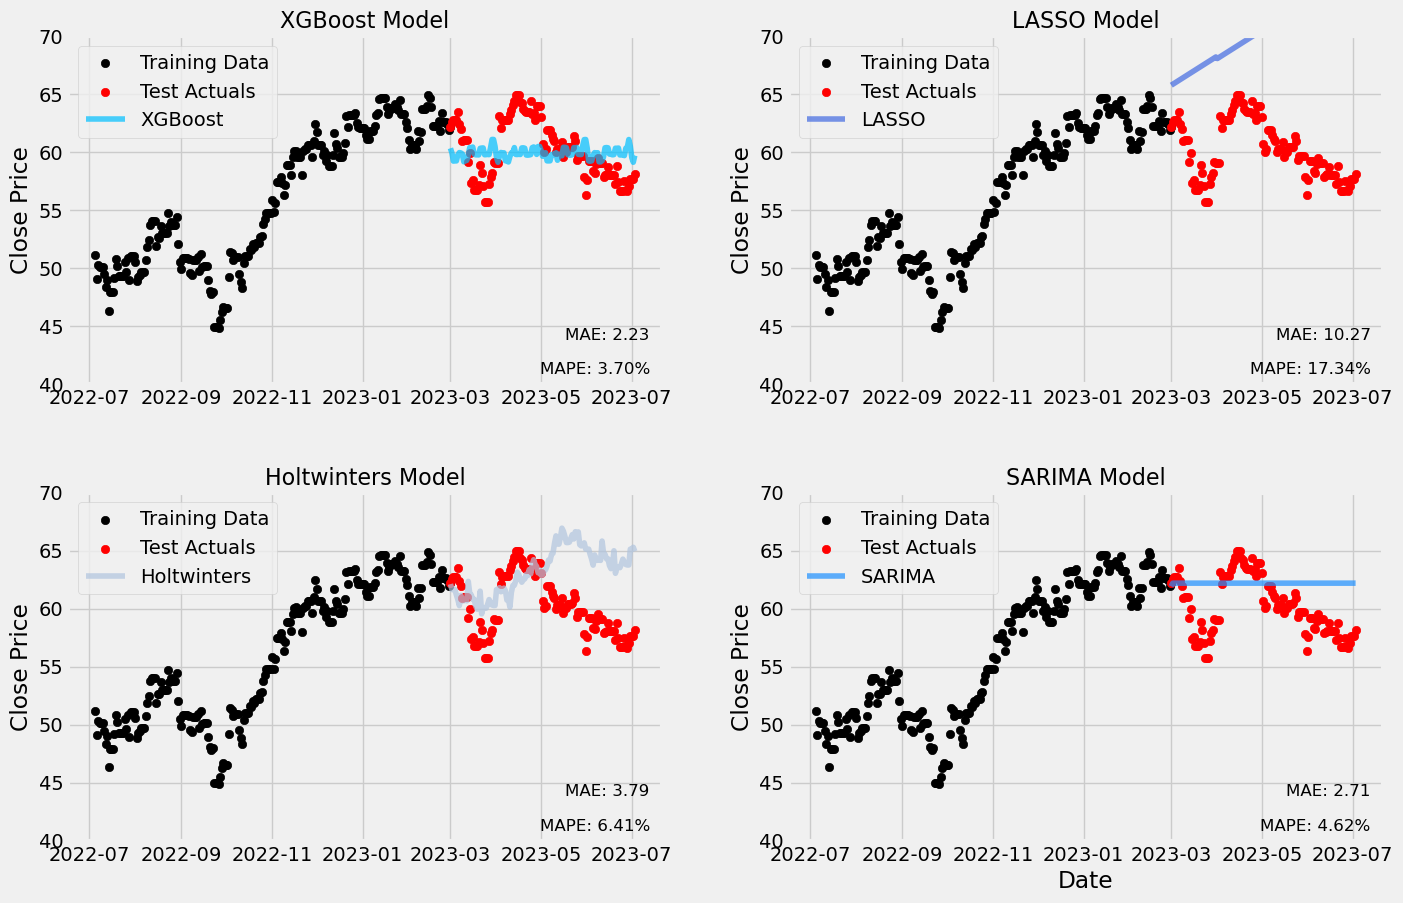

In [ ]:
def plot_model_result(ax, prediction, model_name, color, mape, mae):
    '''
    Plot model results.
    
    prediction : DataFrame
    model_name : str
    color : str
    mape : float
        Mean Absolute Percentage Error
    mae : float
        Mean Absolute Error
    
    return ax
    '''
    # Training and Test Actuals
    ax.scatter(x=train.index, y=train['Close'], label='Training Data', color='black')
    ax.scatter(x=test.index, y=test['Close'], label='Test Actuals', color='red')

    # Model Results
    ax.plot(prediction['Close'], label=model_name, color=color, alpha=0.7)
    
    # Set Y Axis
    ax.set_ylim(40, 70)  # Adjust the y-axis limits based on your data
    
    # Set Axis labels
    ax.set_ylabel("Close Price")
    ax.legend(loc='best')
    ax.set_title("{} Model".format(model_name), fontsize=16)
    
    # Add MAPE and MAE as text in the plot
    ax.text(0.98, 0.02, "MAPE: {:.2f}%".format(mape), transform=ax.transAxes, fontsize=12,
            horizontalalignment='right', verticalalignment='bottom')
    ax.text(0.98, 0.12, "MAE: {:.2f}".format(mae), transform=ax.transAxes, fontsize=12,
            horizontalalignment='right', verticalalignment='bottom')

    return ax

# Create separate subplots for each model
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot Labels, Legends etc
plt.xlabel("Date")

# Plot each model result using the function plot_model_result
axs[0, 0] = plot_model_result(axs[0, 0], XGB_prediction_no_lag, model_name='XGBoost', color='deepskyblue',
                              mape=MAPE(test['Close'], XGB_prediction_no_lag['Close']),
                              mae=mean_absolute_error(test['Close'], XGB_prediction_no_lag['Close']))

axs[0, 1] = plot_model_result(axs[0, 1], LASSO_prediction, model_name='LASSO', color='royalblue',
                              mape=MAPE(test['Close'], LASSO_prediction['Close']),
                              mae=mean_absolute_error(test['Close'], LASSO_prediction['Close']))

axs[1, 0] = plot_model_result(axs[1, 0], Electrostock_prediction, model_name='Holtwinters', color='lightsteelblue',
                              mape=MAPE(test['Close'], Electrostock_prediction['Close']),
                              mae=mean_absolute_error(test['Close'], Electrostock_prediction['Close']))

axs[1, 1] = plot_model_result(axs[1, 1], SARIMA_prediction, model_name='SARIMA', color='dodgerblue',
                              mape=MAPE(test['Close'], SARIMA_prediction['Close']),
                              mae=mean_absolute_error(test['Close'], SARIMA_prediction['Close']))

plt.tight_layout(pad=3.0)
plt.show()


En conclusión, según las métricas MAE y MAPE, el modelo XGBoost es el mejor modelo de los cuatro, ya que tiene el menor error absoluto medio y el menor error porcentual absoluto.